In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from utils import *
import os
import re
import seaborn as sns
from itertools import product
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
import tqdm
import pyranges as pr
%matplotlib inline

### Align nanopore reads and detect ABE and DddA edits

In [2]:
# Create a dictionary for reference regions
ref_range_dict = {
    'HJR244': ('chr11', 5279265, 5282582)
}

for replicate in ["HJR244_3", "HJR244_4"]:
    
    # Create folder for saving plots
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    if not os.path.exists(plot_dir):
        os.system("mkdir " + plot_dir)

    save_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
    if os.path.exists(save_path):
        with open(save_path, "rb") as f:
            ddda_data = pickle.load(f)
        continue
    
    # Initialize ddda_dataset
    ddda_data = ddda_dataset(
        ID = replicate, 
        region_dict = ref_range_dict, 
        genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
        fastq_file = "/home/yanhu/data/DddA/HJR244/fastqs/" + replicate + "/" + replicate + "_merged.fastq.gz", 
        working_dir = "/home/yanhu/data/DddA/HJR244/"
    )
    
    # Load DddA bias model
    bias_model_path = "/home/yanhu/data/DddA/HJR245/bias_dict.pkl"
    ddda_data.load_bias_model(bias_model_path)
    
    # Align reads
    gap_threshold = 500
    ddda_data.align_reads(
        start_gap_threshold = gap_threshold,
        end_gap_threshold = gap_threshold,
        ABE_edits = True
    )

    with open(save_path, "wb") as f:
        pickle.dump(ddda_data, f)

### Export data matrices to tsv files

In [49]:
### Export data slots to tsv files
for replicate in ["HJR244_3", "HJR244_4"]:

    # Load previously initialized ddda_dataset objects
    ddda_data_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
    with open(ddda_data_path, "rb") as f:
        ddda_data = pickle.load(f)

    # Export data matrices
    export_to_tsv(
        ddda_data, 
        export_DddA_edit=True, 
        export_del=False, 
        export_ABE_edit=True,
        export_dir="/home/yanhu/data/DddA/HJR244/data_export/")

Exporting DddA edits for dataset HJR244_3 at locus HJR244
Exporting ABE edits for dataset HJR244_3 at locus HJR244
Exporting aligned reads for dataset HJR244_3 at locus HJR244
Exporting DddA edits for dataset HJR244_4 at locus HJR244
Exporting ABE edits for dataset HJR244_4 at locus HJR244
Exporting aligned reads for dataset HJR244_4 at locus HJR244


### Identify target sites of sgRNAs

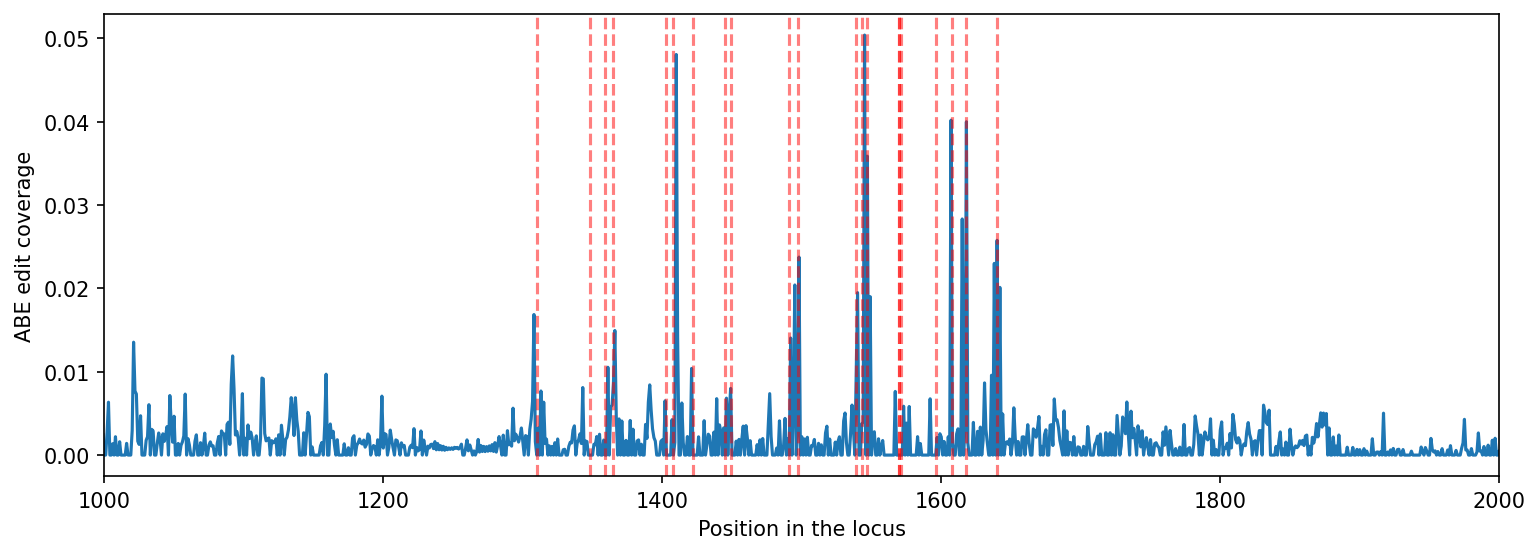

In [3]:
# Specify locus of interest
locus = "HJR244"

# Select replicate
replicate = "HJR244_4"
save_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
with open(save_path, "rb") as f:
    ddda_data = pickle.load(f)

# Load sgRNA sequences
sgRNAs = pd.read_csv("/home/yanhu/data/DddA/HJR244/sgRNA.tsv", sep="\t", header=None)
sgRNAs.columns = ["ID", "sequence"]

# Get sequence of the target locus
ref_seq = ddda_data.ref_seq_dict[locus]

# Find sgRNA positions in the target locus
target_sites = []
target_strands = []
for i, row in sgRNAs.iterrows():
    guide_seq_forward = row["sequence"].upper()
    guide_seq_reverse = str(Seq(guide_seq_forward).reverse_complement())
    forward_match = ref_seq.find(guide_seq_forward)
    reverse_match = ref_seq.find(guide_seq_reverse)
    if forward_match >= 0 and reverse_match == -1:
        targte_site = forward_match + 5 
        target_strands.append("+")
    elif forward_match == -1 and reverse_match >= 0:
        targte_site = reverse_match + 14
        target_strands.append("-")
    else:
        raise ValueError("No match or multiple matches for sgRNA found in the target locus")
    target_sites.append(targte_site)

# Sort sgRNA ABE edit sites by coordinate
site_order = np.argsort(target_sites)
target_sites = np.array(target_sites)[site_order]
target_strands = np.array(target_strands)[site_order]

# Visualize ABE edit coverage and sgRNA positions
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
ABE_coverage = np.array(np.mean(ddda_data.ABE_edit_dict[locus], axis=0))[0]
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(len(ABE_coverage)), ABE_coverage)
for targte_site in target_sites:
    plt.axvline(x = targte_site, color="red", linestyle="dashed", alpha=0.5)
plt.ylabel("ABE edit coverage")
plt.xlabel("Position in the locus")
plt.xlim([1000,2000])
plt.savefig(os.path.join(plot_dir, "ABE_edit_coverage_" + replicate + ".pdf"))

/tmp/ipykernel_2409621/1034320614.py:7: RuntimeWarning: invalid value encountered in divide
  ratio = ABE_coverage / ABE_coverage_ctrl


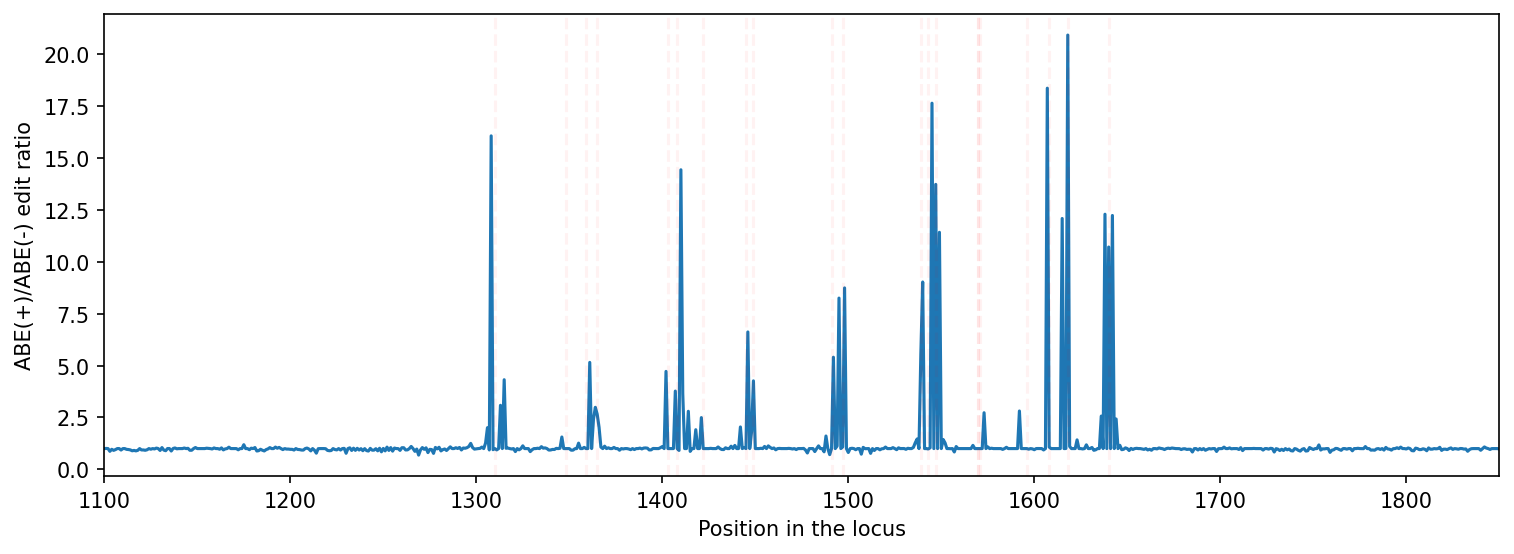

In [4]:
control_path = "/home/yanhu/data/DddA/HJR244/ddda_data_HJR244_1_no_ABE_control.pkl"
with open(control_path, "rb") as f:
    ddda_data = pickle.load(f)
ABE_coverage_ctrl = np.array(np.mean(ddda_data.ABE_edit_dict[locus], axis=0))[0]

# Calculate ratio of ABE editing rates between ABE(+) and ABE(-) group
ratio = ABE_coverage / ABE_coverage_ctrl
ratio[np.isnan(ratio)] = 1

# Visualize results
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
os.system("mkdir -p " + plot_dir)
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(len(ratio)), ratio)
for targte_site in target_sites:
    plt.axvline(x = targte_site, color="red", linestyle="dashed", alpha=0.05)
plt.ylabel("ABE(+)/ABE(-) edit ratio")
plt.xlabel("Position in the locus")
plt.xlim([1100,1850])
plt.savefig(os.path.join(plot_dir, "ABE_edit_ABE(+)_vs_ABE(-)_ratio_" + replicate + ".pdf"))

In [5]:
# First identify bases within a local window of sgRNA target sites
forward_sgRNA_window = np.unique(np.concatenate(
    [np.arange(target_sites[i] - 3, target_sites[i] + 4) for \
     i in range(len(target_sites)) if target_strands[i] == "+"]
))
reverse_sgRNA_window = np.unique(np.concatenate(
    [np.arange(target_sites[i] - 3, target_sites[i] + 4) for \
     i in range(len(target_sites)) if target_strands[i] == "-"]
))

# Then identify positions of As on both strands
region_seq = ddda_data.ref_seq_dict[locus]
forward_A_pos = [i for i in range(len(region_seq)) if region_seq[i] == "A"]
reverse_A_pos = [i for i in range(len(region_seq)) if region_seq[i] == "T"]

# Find editable As with sgRNAs on the matched strand
forward_editable_pos = np.intersect1d(forward_A_pos, forward_sgRNA_window)
reverse_editable_pos = np.intersect1d(reverse_A_pos, reverse_sgRNA_window)
editable_pos = np.union1d(forward_editable_pos, reverse_editable_pos)

# Also find non-editable (non-target) As
forward_uneditable_pos = np.intersect1d(
    forward_A_pos, np.setdiff1d(reverse_sgRNA_window, forward_sgRNA_window)
)
reverse_uneditable_pos = np.intersect1d(
    reverse_A_pos, np.setdiff1d(forward_sgRNA_window, reverse_sgRNA_window)
)
uneditable_pos = np.union1d(forward_uneditable_pos, reverse_uneditable_pos)

Text(0.5, 0, 'Position')

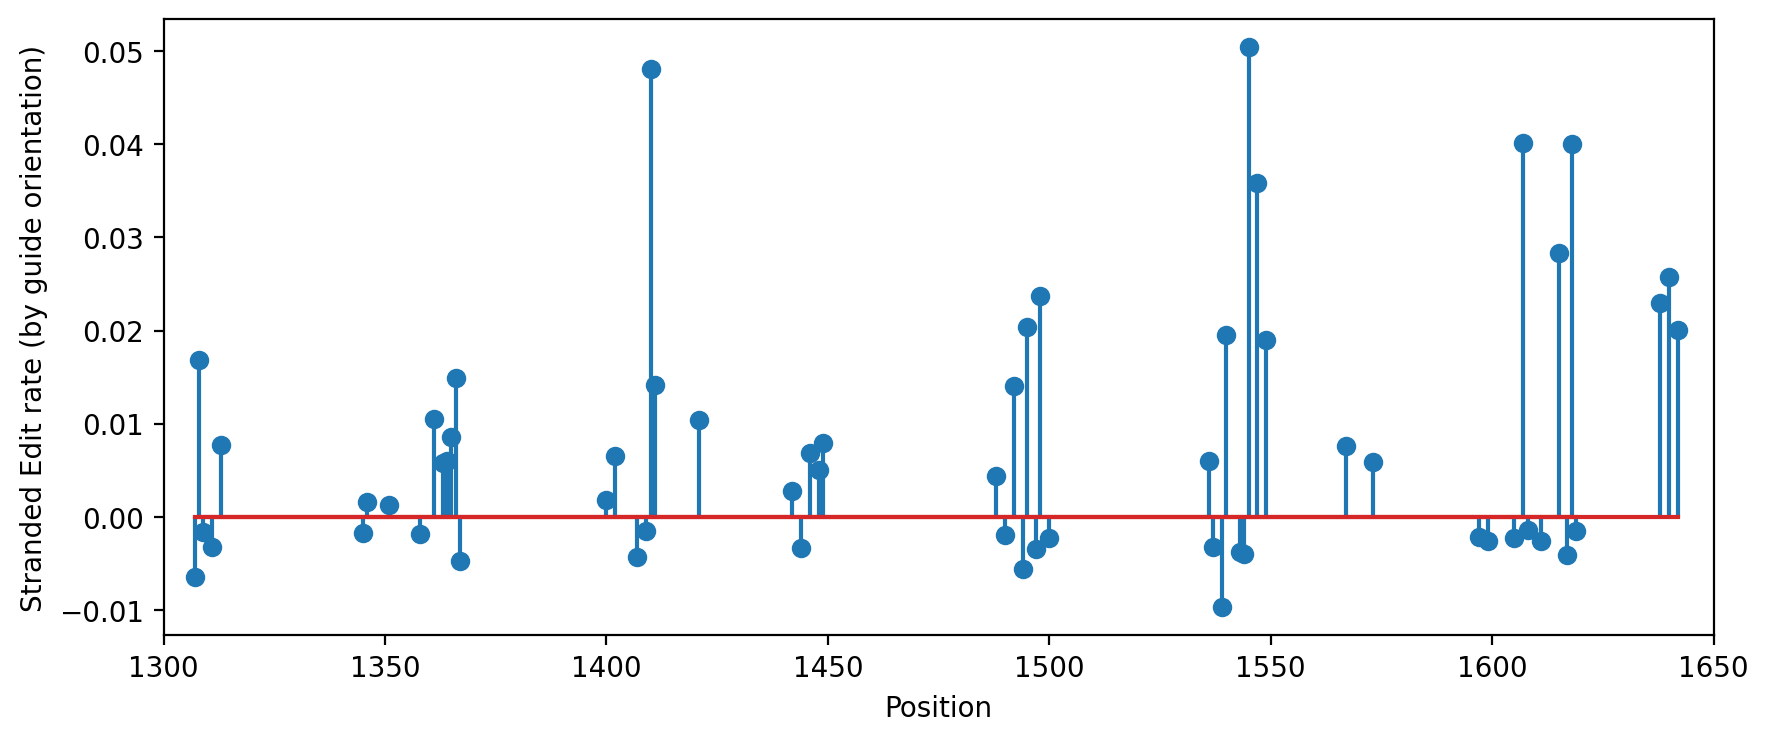

In [8]:
plt.figure(dpi=200, figsize=(10,4))
plt.stem(editable_pos, ABE_coverage[editable_pos]) 
plt.stem(uneditable_pos, ABE_coverage[uneditable_pos] * -1)
plt.ylabel("Stranded Edit rate (by guide orientation)")
plt.xlim([1300,1650])
plt.xlabel("Position")

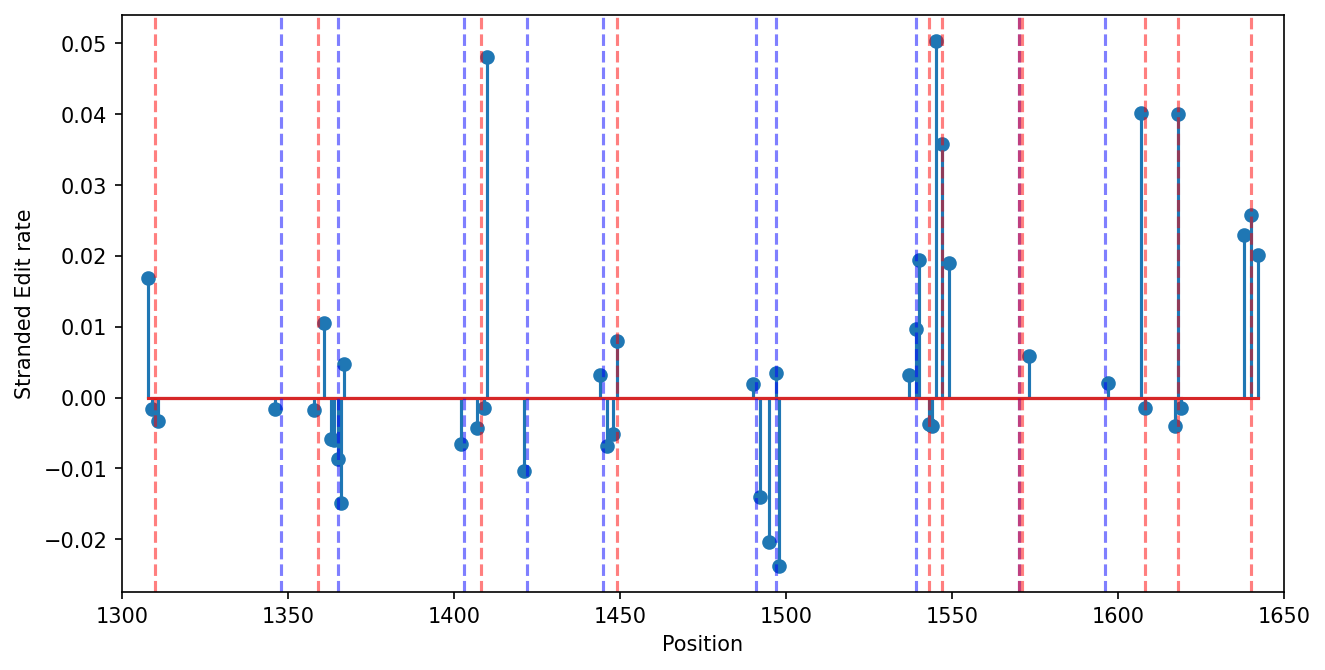

In [10]:
vicinity_pos = np.concatenate(
    [np.arange(target_sites[i] - 2, target_sites[i] + 3) for \
     i in range(len(target_sites))]
)
forward_vicinity_A_pos = np.intersect1d(vicinity_pos, forward_A_pos)
reverse_vicinity_A_pos = np.intersect1d(vicinity_pos, reverse_A_pos)

plt.figure(dpi=150, figsize=(10, 5))
plt.stem(forward_vicinity_A_pos, ABE_coverage[forward_vicinity_A_pos])
plt.stem(reverse_vicinity_A_pos, -1 * ABE_coverage[reverse_vicinity_A_pos])
for targte_site, target_strand in zip(target_sites, target_strands):
    color = "red" if target_strand == "+" else "blue"
    plt.axvline(x = targte_site, color=color, linestyle="dashed", alpha=0.5)
plt.xlim([1300,1650])
plt.ylabel("Stranded Edit rate")
plt.xlabel("Position")

# Save plot
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
os.system("mkdir -p " + plot_dir)
plt.savefig(os.path.join(plot_dir, "ABE_edit_sgRNA_strand_compare_" + replicate + ".pdf"))
plt.show()

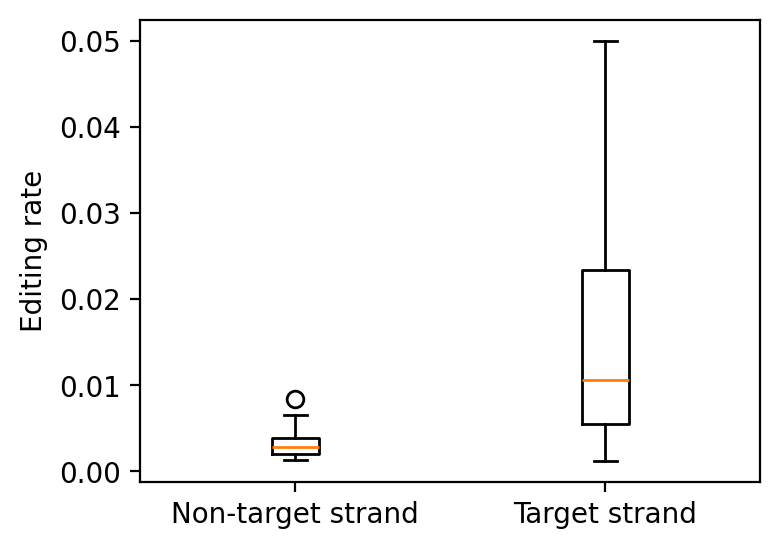

In [34]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,3))
ax.boxplot(
    [ABE_coverage[uneditable_pos], ABE_coverage[editable_pos]])
ax.set_xticklabels(['Non-target strand', "Target strand"])
ax.set_ylabel("Editing rate")

# Save plot
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
os.system("mkdir -p " + plot_dir)
plt.savefig(os.path.join(plot_dir, "ABE_edit_sgRNA_strand_compare_boxplot_" + replicate + ".pdf"))
plt.show()

### Compare ABE edit rates to our negative control without ABE treatment

In [33]:
target_A_pos = np.intersect1d(np.where(ratio > 2)[0], editable_pos)

### Calculate impact of ABE edits on accessibility measured by DddA edits

In [10]:
ABE_results = {}
for replicate in ["HJR244_3", "HJR244_4"]:

    with open("/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl", "rb") as f:
        ddda_data = pickle.load(f)
    
    # Compute a read-by-position matrix of ABE edit labels
    ABE_matrix = ddda_data.ABE_edit_dict[locus]

    # Get strandedness of each read
    strands = ddda_data.read_strands[locus]
    strand_read_inds = {
        "C_to_T" : np.where(strands == 0)[0],
        "G_to_A" : np.where(strands == 1)[0]
    }

    ABE_results[replicate] = {}
    for A_pos in target_A_pos:
    
        print("Processing A at position", A_pos)

        ################################################################
        # Select reads with and without ABE edits by the current sgRNA #
        ################################################################
    
        # Find reads where the sgRNA target site is covered by a editetion
        target_site_edit = np.squeeze(np.array(ABE_matrix[:, A_pos].todense()))
        edited_read_inds = np.where(target_site_edit == 1)[0]
        
        # Only keep reads where positions outside of the vicinity of the sgRNA target site are not editeted
        upstream_filter = np.squeeze(np.array(np.max(ABE_matrix[:, :A_pos], axis=1).todense())) == 0
        downstream_filter = np.squeeze(np.array(np.max(ABE_matrix[:,(A_pos + 1):], axis=1).todense())) == 0
        filter = np.where(upstream_filter & downstream_filter)[0]
        edited_read_inds = np.intersect1d(edited_read_inds, filter)
        
        # Separately, also find reads without any edits as a control
        read_with_edit = np.squeeze(np.array(np.max(ABE_matrix, axis=1).todense()))
        unedited_read_inds = np.where(read_with_edit == 0)[0]

        ###################################
        # Down-sampling and deduplication #
        ###################################
        
        # Down-sample the number of reads
        min_num = min(len(edited_read_inds), len(unedited_read_inds), 10000)
        if min_num < 100:
            continue
        print(min_num)
        edited_read_inds = np.random.choice(edited_read_inds, min_num, replace=False)
        unedited_read_inds = np.random.choice(unedited_read_inds, min_num, replace=False)
        
        # De-duplicate reads
        edited_read_ids = ddda_data.dedup_reads(
            locus = locus, 
            read_ids = np.array(ddda_data.read_ids[locus])[edited_read_inds]
        )
        unedited_read_ids = ddda_data.dedup_reads(
            locus = locus, 
            read_ids = np.array(ddda_data.read_ids[locus])[unedited_read_inds]
        )
        
        # For each read ID, get its index in the full read ID list
        locus_ids = ddda_data.read_ids[locus]
        locus_id_dict = dict(zip(locus_ids, np.arange(len(locus_ids))))
        edited_read_inds = np.array([*map(locus_id_dict.get, edited_read_ids)])
        unedited_read_inds = np.array([*map(locus_id_dict.get, unedited_read_ids)])

        #################################################################
        # Calculate DddA editing rate for ABE edited and unedited reads #
        #################################################################
        
        ABE_results[replicate][A_pos] = {}
        for strand in  ["C_to_T", "G_to_A"]:

            # Calculate average DddA editing rate on ABE edited reads for both C-to-T and G-to-A strands
            edited_read_inds_stranded = np.intersect1d(edited_read_inds, strand_read_inds[strand])
            ABE_edited_DddA_edits = np.array(np.mean(ddda_data.edit_dict[locus][edited_read_inds_stranded, :], axis=0))[0, :]
    
            # Calculate average DddA editing rate on ABE unedited reads for both C-to-T and G-to-A strands
            unedited_read_inds_stranded = np.intersect1d(unedited_read_inds, strand_read_inds[strand])
            ABE_unedited_DddA_edits = np.array(np.mean(ddda_data.edit_dict[locus][unedited_read_inds_stranded, :], axis=0))[0, :]
    
            strand_results = {
                "edited_read_inds" : edited_read_inds_stranded,
                "unedited_read_inds" : unedited_read_inds_stranded,
                "ABE_edited_DddA_edits" : ABE_edited_DddA_edits,
                "ABE_unedited_DddA_edits" : ABE_unedited_DddA_edits
            }
    
            ABE_results[replicate][A_pos][strand] = strand_results

Processing A at position 1308
2703


100%|████████████████████████████████████████████████████████████████████| 2703/2703 [00:00<00:00, 7500.95it/s]
2703it [00:00, 1045963.99it/s]
100%|████████████████████████████████████████████████████████████████████| 2703/2703 [00:00<00:00, 8223.55it/s]
2703it [00:00, 1043076.98it/s]


Processing A at position 1313
234


100%|██████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 7907.41it/s]
234it [00:00, 808457.28it/s]
100%|██████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 8153.48it/s]
234it [00:00, 654311.42it/s]


Processing A at position 1361
3029


100%|████████████████████████████████████████████████████████████████████| 3029/3029 [00:00<00:00, 8335.84it/s]
3029it [00:00, 1162674.73it/s]
100%|████████████████████████████████████████████████████████████████████| 3029/3029 [00:00<00:00, 8220.08it/s]
3029it [00:00, 1190344.50it/s]


Processing A at position 1363
253


100%|██████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 7935.98it/s]
253it [00:00, 878442.81it/s]
100%|██████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 7982.66it/s]
253it [00:00, 644298.06it/s]


Processing A at position 1364
239


100%|██████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 7907.60it/s]
239it [00:00, 847369.95it/s]
100%|██████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 7858.01it/s]
239it [00:00, 630464.56it/s]


Processing A at position 1365
265


100%|██████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 8024.68it/s]
265it [00:00, 889904.37it/s]
100%|██████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 8053.75it/s]
265it [00:00, 875189.42it/s]


Processing A at position 1366
893


100%|██████████████████████████████████████████████████████████████████████| 893/893 [00:00<00:00, 8106.63it/s]
893it [00:00, 902968.53it/s]
100%|██████████████████████████████████████████████████████████████████████| 893/893 [00:00<00:00, 8016.01it/s]
893it [00:00, 1119065.87it/s]


Processing A at position 1402
1109


100%|████████████████████████████████████████████████████████████████████| 1109/1109 [00:00<00:00, 8116.09it/s]
1109it [00:00, 1189333.45it/s]
100%|████████████████████████████████████████████████████████████████████| 1109/1109 [00:00<00:00, 8150.30it/s]
1109it [00:00, 1149934.03it/s]


Processing A at position 1410
10000


100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8197.72it/s]
10000it [00:00, 857573.04it/s]
100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8259.12it/s]
10000it [00:00, 789798.52it/s]


Processing A at position 1411
496


100%|██████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 8240.35it/s]
496it [00:00, 1018792.74it/s]
100%|██████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 8165.35it/s]
496it [00:00, 879279.28it/s]


Processing A at position 1421
2088


100%|████████████████████████████████████████████████████████████████████| 2088/2088 [00:00<00:00, 8189.72it/s]
2088it [00:00, 1212978.77it/s]
100%|████████████████████████████████████████████████████████████████████| 2088/2088 [00:00<00:00, 8224.69it/s]
2088it [00:00, 1202981.70it/s]


Processing A at position 1442
219


100%|██████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 8086.28it/s]
219it [00:00, 852880.76it/s]
100%|██████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 7981.79it/s]
219it [00:00, 629576.82it/s]


Processing A at position 1446
969


100%|██████████████████████████████████████████████████████████████████████| 969/969 [00:00<00:00, 8017.99it/s]
969it [00:00, 1142293.59it/s]
100%|██████████████████████████████████████████████████████████████████████| 969/969 [00:00<00:00, 8034.37it/s]
969it [00:00, 990080.53it/s]


Processing A at position 1448
224


100%|██████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 7886.81it/s]
224it [00:00, 814145.66it/s]
100%|██████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 8000.99it/s]
224it [00:00, 879704.21it/s]


Processing A at position 1449
2491


100%|████████████████████████████████████████████████████████████████████| 2491/2491 [00:00<00:00, 8191.79it/s]
2491it [00:00, 1148133.11it/s]
100%|████████████████████████████████████████████████████████████████████| 2491/2491 [00:00<00:00, 8139.08it/s]
2491it [00:00, 1105141.87it/s]


Processing A at position 1492
2356


100%|████████████████████████████████████████████████████████████████████| 2356/2356 [00:00<00:00, 8143.42it/s]
2356it [00:00, 1198663.30it/s]
100%|████████████████████████████████████████████████████████████████████| 2356/2356 [00:00<00:00, 8187.17it/s]
2356it [00:00, 1153066.54it/s]


Processing A at position 1495
500


100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 8143.99it/s]
500it [00:00, 808151.06it/s]
100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7916.41it/s]
500it [00:00, 1070521.69it/s]


Processing A at position 1498
1442


100%|████████████████████████████████████████████████████████████████████| 1442/1442 [00:00<00:00, 8134.18it/s]
1442it [00:00, 1129868.55it/s]
100%|████████████████████████████████████████████████████████████████████| 1442/1442 [00:00<00:00, 8091.62it/s]
1442it [00:00, 1181978.97it/s]


Processing A at position 1540
466


100%|██████████████████████████████████████████████████████████████████████| 466/466 [00:00<00:00, 8219.39it/s]
466it [00:00, 986148.17it/s]
100%|██████████████████████████████████████████████████████████████████████| 466/466 [00:00<00:00, 7990.10it/s]
466it [00:00, 838860.80it/s]


Processing A at position 1545
2762


100%|████████████████████████████████████████████████████████████████████| 2762/2762 [00:00<00:00, 8122.02it/s]
2762it [00:00, 1018611.42it/s]
100%|████████████████████████████████████████████████████████████████████| 2762/2762 [00:00<00:00, 8125.42it/s]
2762it [00:00, 1175869.64it/s]


Processing A at position 1547
895


100%|██████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 7984.43it/s]
895it [00:00, 1128314.42it/s]
100%|██████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 8090.78it/s]
895it [00:00, 1124596.19it/s]


Processing A at position 1549
279


100%|██████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 7937.02it/s]
279it [00:00, 946007.13it/s]
100%|██████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 7914.58it/s]
279it [00:00, 917093.12it/s]


Processing A at position 1573
1643


100%|████████████████████████████████████████████████████████████████████| 1643/1643 [00:00<00:00, 8259.41it/s]
1643it [00:00, 1216029.91it/s]
100%|████████████████████████████████████████████████████████████████████| 1643/1643 [00:00<00:00, 8130.06it/s]
1643it [00:00, 1206661.09it/s]


Processing A at position 1607
10000


100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8284.31it/s]
10000it [00:00, 1018925.27it/s]
100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8212.23it/s]
10000it [00:00, 720373.73it/s]


Processing A at position 1615
465


100%|██████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 8002.89it/s]
465it [00:00, 1016337.34it/s]
100%|██████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 8116.62it/s]
465it [00:00, 1037973.05it/s]


Processing A at position 1618
4707


100%|████████████████████████████████████████████████████████████████████| 4707/4707 [00:00<00:00, 8232.46it/s]
4707it [00:00, 1139938.16it/s]
100%|████████████████████████████████████████████████████████████████████| 4707/4707 [00:00<00:00, 8157.15it/s]
4707it [00:00, 1083150.76it/s]


Processing A at position 1638
332


100%|██████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 8036.64it/s]
332it [00:00, 889213.87it/s]
100%|██████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 8041.10it/s]
332it [00:00, 778372.79it/s]


Processing A at position 1640
596


100%|██████████████████████████████████████████████████████████████████████| 596/596 [00:00<00:00, 8142.85it/s]
596it [00:00, 934506.61it/s]
100%|██████████████████████████████████████████████████████████████████████| 596/596 [00:00<00:00, 8148.69it/s]
596it [00:00, 818802.88it/s]


Processing A at position 1642
346


100%|██████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 8015.01it/s]
346it [00:00, 672488.04it/s]
100%|██████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 7884.03it/s]
346it [00:00, 732944.03it/s]


Processing A at position 1308
2814


100%|████████████████████████████████████████████████████████████████████| 2814/2814 [00:00<00:00, 8119.14it/s]
2814it [00:00, 1064271.55it/s]
100%|████████████████████████████████████████████████████████████████████| 2814/2814 [00:00<00:00, 8085.56it/s]
2814it [00:00, 1109283.03it/s]


Processing A at position 1313
267


100%|██████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 7961.66it/s]
267it [00:00, 613968.84it/s]
100%|██████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 7961.89it/s]
267it [00:00, 923230.97it/s]


Processing A at position 1361
3216


100%|████████████████████████████████████████████████████████████████████| 3216/3216 [00:00<00:00, 8209.92it/s]
3216it [00:00, 915245.06it/s]
100%|████████████████████████████████████████████████████████████████████| 3216/3216 [00:00<00:00, 8181.84it/s]
3216it [00:00, 961911.26it/s]


Processing A at position 1363
285


100%|██████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 7886.37it/s]
285it [00:00, 884154.32it/s]
100%|██████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 7978.01it/s]
285it [00:00, 587986.54it/s]


Processing A at position 1364
257


100%|██████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 7926.70it/s]
257it [00:00, 548847.32it/s]
100%|██████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 7976.32it/s]
257it [00:00, 803231.09it/s]


Processing A at position 1365
291


100%|██████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 7873.05it/s]
291it [00:00, 502694.59it/s]
100%|██████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 7963.97it/s]
291it [00:00, 953548.80it/s]


Processing A at position 1366
1290


100%|████████████████████████████████████████████████████████████████████| 1290/1290 [00:00<00:00, 8072.89it/s]
1290it [00:00, 1129572.48it/s]
100%|████████████████████████████████████████████████████████████████████| 1290/1290 [00:00<00:00, 8119.43it/s]
1290it [00:00, 1142934.55it/s]


Processing A at position 1402
1180


100%|████████████████████████████████████████████████████████████████████| 1180/1180 [00:00<00:00, 8045.55it/s]
1180it [00:00, 936653.81it/s]
100%|████████████████████████████████████████████████████████████████████| 1180/1180 [00:00<00:00, 8125.49it/s]
1180it [00:00, 1166457.39it/s]


Processing A at position 1410
10000


100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8170.99it/s]
10000it [00:00, 1029403.36it/s]
100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8217.43it/s]
10000it [00:00, 715617.20it/s]


Processing A at position 1411
615


100%|██████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 8167.44it/s]
615it [00:00, 1086103.98it/s]
100%|██████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 8033.19it/s]
615it [00:00, 903185.21it/s]


Processing A at position 1421
2535


100%|████████████████████████████████████████████████████████████████████| 2535/2535 [00:00<00:00, 8166.10it/s]
2535it [00:00, 1216400.94it/s]
100%|████████████████████████████████████████████████████████████████████| 2535/2535 [00:00<00:00, 8150.93it/s]
2535it [00:00, 1147109.79it/s]


Processing A at position 1442
186


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 8031.18it/s]
186it [00:00, 554470.89it/s]
100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 7799.30it/s]
186it [00:00, 808435.80it/s]


Processing A at position 1446
938


100%|██████████████████████████████████████████████████████████████████████| 938/938 [00:00<00:00, 8090.97it/s]
938it [00:00, 1044955.42it/s]
100%|██████████████████████████████████████████████████████████████████████| 938/938 [00:00<00:00, 8046.73it/s]
938it [00:00, 1123110.81it/s]


Processing A at position 1448
286


100%|██████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 7882.22it/s]
286it [00:00, 852573.52it/s]
100%|██████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 7858.98it/s]
286it [00:00, 943058.92it/s]


Processing A at position 1449
2519


100%|████████████████████████████████████████████████████████████████████| 2519/2519 [00:00<00:00, 8050.94it/s]
2519it [00:00, 1200210.36it/s]
100%|████████████████████████████████████████████████████████████████████| 2519/2519 [00:00<00:00, 8081.75it/s]
2519it [00:00, 1156716.86it/s]


Processing A at position 1492
2762


100%|████████████████████████████████████████████████████████████████████| 2762/2762 [00:00<00:00, 8197.79it/s]
2762it [00:00, 1118859.15it/s]
100%|████████████████████████████████████████████████████████████████████| 2762/2762 [00:00<00:00, 8181.65it/s]
2762it [00:00, 1154196.24it/s]


Processing A at position 1495
609


100%|██████████████████████████████████████████████████████████████████████| 609/609 [00:00<00:00, 8158.69it/s]
609it [00:00, 1102906.36it/s]
100%|██████████████████████████████████████████████████████████████████████| 609/609 [00:00<00:00, 8051.83it/s]
609it [00:00, 904508.19it/s]


Processing A at position 1498
1777


100%|████████████████████████████████████████████████████████████████████| 1777/1777 [00:00<00:00, 8146.13it/s]
1777it [00:00, 1224257.26it/s]
100%|████████████████████████████████████████████████████████████████████| 1777/1777 [00:00<00:00, 8060.20it/s]
1777it [00:00, 1192906.24it/s]


Processing A at position 1540
614


100%|██████████████████████████████████████████████████████████████████████| 614/614 [00:00<00:00, 7874.75it/s]
614it [00:00, 859867.33it/s]
100%|██████████████████████████████████████████████████████████████████████| 614/614 [00:00<00:00, 7981.70it/s]
614it [00:00, 900140.74it/s]


Processing A at position 1545
3090


100%|████████████████████████████████████████████████████████████████████| 3090/3090 [00:00<00:00, 8269.45it/s]
3090it [00:00, 1139475.94it/s]
100%|████████████████████████████████████████████████████████████████████| 3090/3090 [00:00<00:00, 8236.14it/s]
3090it [00:00, 1041079.55it/s]


Processing A at position 1547
978


100%|██████████████████████████████████████████████████████████████████████| 978/978 [00:00<00:00, 8116.85it/s]
978it [00:00, 928901.57it/s]
100%|██████████████████████████████████████████████████████████████████████| 978/978 [00:00<00:00, 7998.70it/s]
978it [00:00, 1097386.12it/s]


Processing A at position 1549
345


100%|██████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 8038.77it/s]
345it [00:00, 953879.29it/s]
100%|██████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 7891.55it/s]
345it [00:00, 601927.99it/s]


Processing A at position 1573
1839


100%|████████████████████████████████████████████████████████████████████| 1839/1839 [00:00<00:00, 7740.82it/s]
1839it [00:00, 1140686.94it/s]
100%|████████████████████████████████████████████████████████████████████| 1839/1839 [00:00<00:00, 8109.34it/s]
1839it [00:00, 1034235.06it/s]


Processing A at position 1607
10000


100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8209.98it/s]
10000it [00:00, 998120.98it/s]
100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8287.05it/s]
10000it [00:00, 894708.50it/s]


Processing A at position 1615
506


100%|██████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 8076.28it/s]
506it [00:00, 968652.59it/s]
100%|██████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 8190.67it/s]
506it [00:00, 773157.68it/s]


Processing A at position 1618
4897


100%|████████████████████████████████████████████████████████████████████| 4897/4897 [00:00<00:00, 8196.91it/s]
4897it [00:00, 1117249.06it/s]
100%|████████████████████████████████████████████████████████████████████| 4897/4897 [00:00<00:00, 8177.99it/s]
4897it [00:00, 1113493.80it/s]


Processing A at position 1638
298


100%|██████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 8017.03it/s]
298it [00:00, 911007.72it/s]
100%|██████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 8053.18it/s]
298it [00:00, 756141.92it/s]


Processing A at position 1640
729


100%|██████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8110.92it/s]
729it [00:00, 1124548.59it/s]
100%|██████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8151.27it/s]
729it [00:00, 1111063.81it/s]


Processing A at position 1642
311


100%|██████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 8081.81it/s]
311it [00:00, 902718.72it/s]
100%|██████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 7879.74it/s]
311it [00:00, 874868.24it/s]


In [11]:
with open("/home/yanhu/data/DddA/HJR244/sgRNA_ABE_single_bp_results.pkl", "wb") as f:
    pickle.dump(ABE_results, f)

In [34]:
with open("/home/yanhu/data/DddA/HJR244/sgRNA_ABE_single_bp_results.pkl", "rb") as f:
    ABE_results = pickle.load(f)

### Compare results across sgRNAs and replicates

In [ ]:
# Find sgRNAs shared by both replicates
kept_A_pos = np.intersect1d(
    list(ABE_results["HJR244_3"].keys()),
    list(ABE_results["HJR244_4"].keys())
)

ABE_effect = {}
for replicate in ["HJR244_3", "HJR244_4"]:
    effect_mtx = []
    for A_pos in kept_A_pos:

        # Calculate effect of sgRNA on DddA edits
        CT_ABE_edited_DddA_edits = ABE_results[replicate][A_pos]["C_to_T"]["ABE_edited_DddA_edits"]
        CT_ABE_unedited_DddA_edits = ABE_results[replicate][A_pos]["C_to_T"]["ABE_unedited_DddA_edits"]
        GA_ABE_edited_DddA_edits = ABE_results[replicate][A_pos]["G_to_A"]["ABE_edited_DddA_edits"]
        GA_ABE_unedited_DddA_edits = ABE_results[replicate][A_pos]["G_to_A"]["ABE_unedited_DddA_edits"]
        diff_edits = (CT_ABE_edited_DddA_edits - CT_ABE_unedited_DddA_edits + GA_ABE_edited_DddA_edits - GA_ABE_unedited_DddA_edits) / 2
        diff_edits = np.convolve(diff_edits, np.ones(100), mode="same") / 100
        effect_mtx.append(diff_edits)
        
    ABE_effect[replicate] = np.array(effect_mtx)

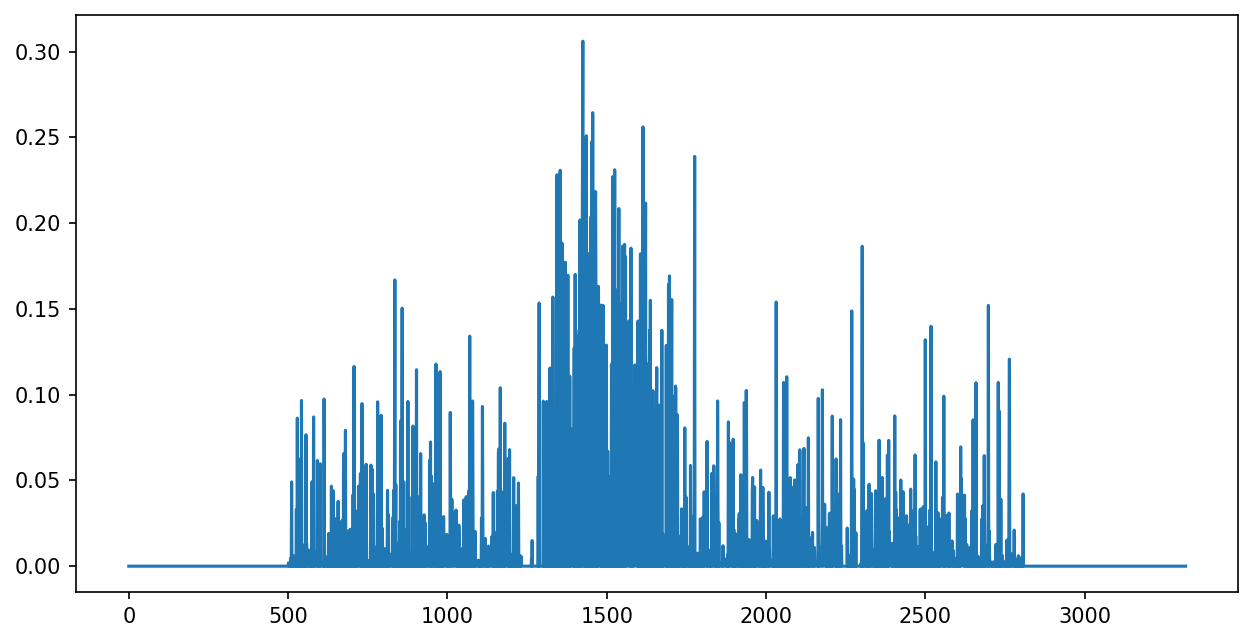

In [48]:
replicate = "HJR244_4"
with open("/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl", "rb") as f:
    ddda_data = pickle.load(f)

plt.figure(dpi=150, figsize=(10,5))
plt.plot(np.array(np.mean(ddda_data.edit_dict[locus][:10000, :], axis=0))[0])

In [36]:
kept_A_pos

array([1308, 1313, 1361, 1363, 1364, 1365, 1366, 1402, 1410, 1411, 1421,
       1442, 1446, 1448, 1449, 1492, 1495, 1498, 1540, 1545, 1547, 1549,
       1573, 1607, 1615, 1618, 1638, 1640, 1642])

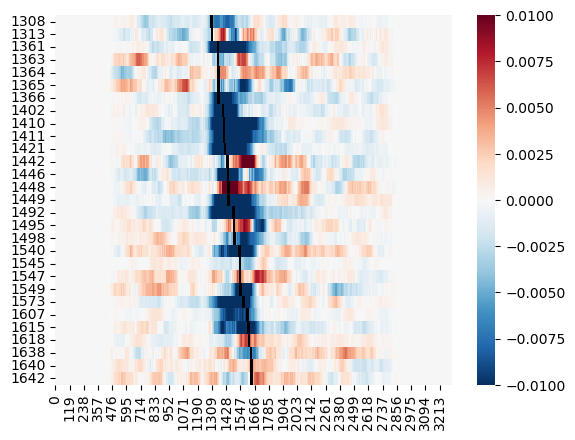

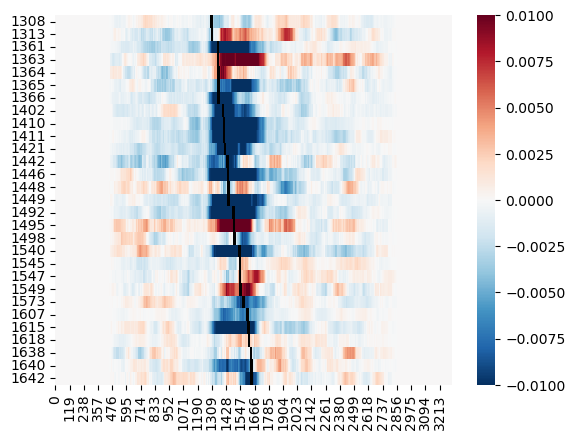

In [37]:
for replicate in ["HJR244_3", "HJR244_4"]:
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    
    # Generate a mask to visualize location of ABE target sites
    ABE_mask = []
    locus_len = ABE_effect[replicate].shape[1]
    for A_pos in kept_A_pos:
        ABE_vec = np.zeros(locus_len)
        # We use a wide interval mostly to help visualize. Otherwise the line is too thin to see
        ABE_vec[max(0, A_pos - 10):min(A_pos + 10, locus_len)] = 1 
        ABE_mask.append(ABE_vec)
    ABE_mask = np.array(ABE_mask) > 0
    
    # Set mask color to be black
    import matplotlib as mpl
    cmap = mpl.colormaps.get_cmap('RdBu_r')
    cmap.set_bad("k")
    
    # Visualize base edit impact using a heatmap
    ax = sns.heatmap(
        ABE_effect[replicate], 
        cmap=cmap, vmax=0.01, vmin=-0.01, 
        yticklabels=kept_A_pos,
        mask=ABE_mask)
    ax.collections[0].set_rasterized(True)
    plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_edit_heatmap_" + replicate + ".pdf"))
    plt.show()

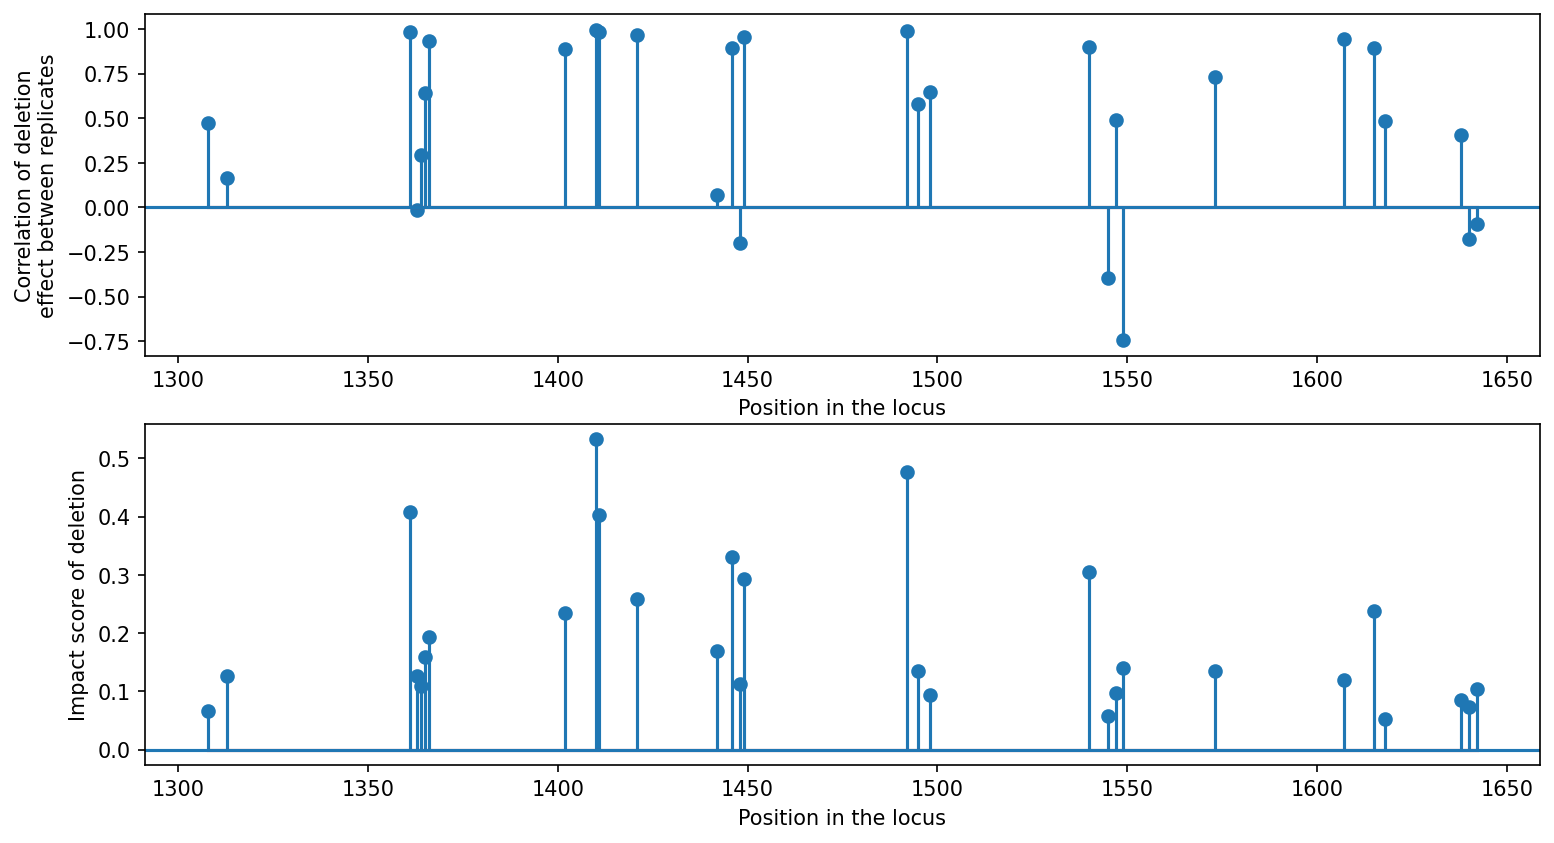

In [15]:
# Calculate correlation between replicates for each sgRNA
replicate_cor = []
for A_pos_ind in range(len(kept_A_pos)):
    replicate_cor.append(ss.pearsonr(
        ABE_effect["HJR244_3"][A_pos_ind, :],
        ABE_effect["HJR244_4"][A_pos_ind, :]
    ).statistic)

# Calculate overall impact for each sgRNA
impact_score = []
for A_pos_ind in range(len(kept_A_pos)):
    score_1 = np.sqrt(np.sum(np.power(ABE_effect["HJR244_3"][A_pos_ind, :], 2)))
    score_2 = np.sqrt(np.sum(np.power(ABE_effect["HJR244_4"][A_pos_ind, :], 2)))
    impact_score.append(min(score_1, score_2))

plot_dir = "/home/yanhu/data/DddA/HJR244/plots/ABE_diff_edit_reproducibility/"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(12, 6.5))

ax[0].stem(kept_A_pos, replicate_cor) 
ax[0].set_ylabel("Correlation of deletion\neffect between replicates")
ax[0].set_xlabel("Position in the locus")
ax[0].axhline(y=0)

ax[1].stem(kept_A_pos, impact_score) 
ax[1].set_ylabel("Impact score of deletion")
ax[1].set_xlabel("Position in the locus")
ax[1].axhline(y=0)
plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_edit_reproducibility.pdf"))

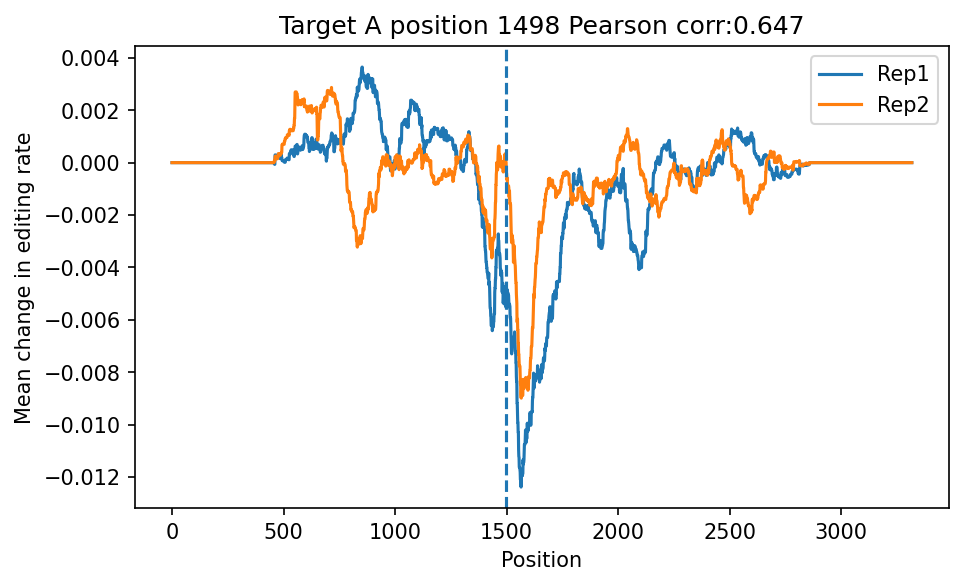

In [16]:
plt.figure(dpi=150, figsize=(7, 4))
A_pos_ind = 17
A_pos = kept_A_pos[A_pos_ind]
cor = ss.pearsonr(ABE_effect["HJR244_3"][A_pos_ind], ABE_effect["HJR244_4"][A_pos_ind])[0]
plt.title("Target A position " + str(A_pos) + " Pearson corr:" + str(round(cor, 3)))
plt.xlabel("Position")
plt.ylabel("Mean change in editing rate")
plt.plot(ABE_effect["HJR244_3"][A_pos_ind], label="Rep1")
plt.plot(ABE_effect["HJR244_4"][A_pos_ind], label="Rep2")
plt.axvline(x=A_pos, linestyle="dashed")
plt.legend()
plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_edit_reproducibility_sgRNA_" + str(A_pos) + ".pdf"))

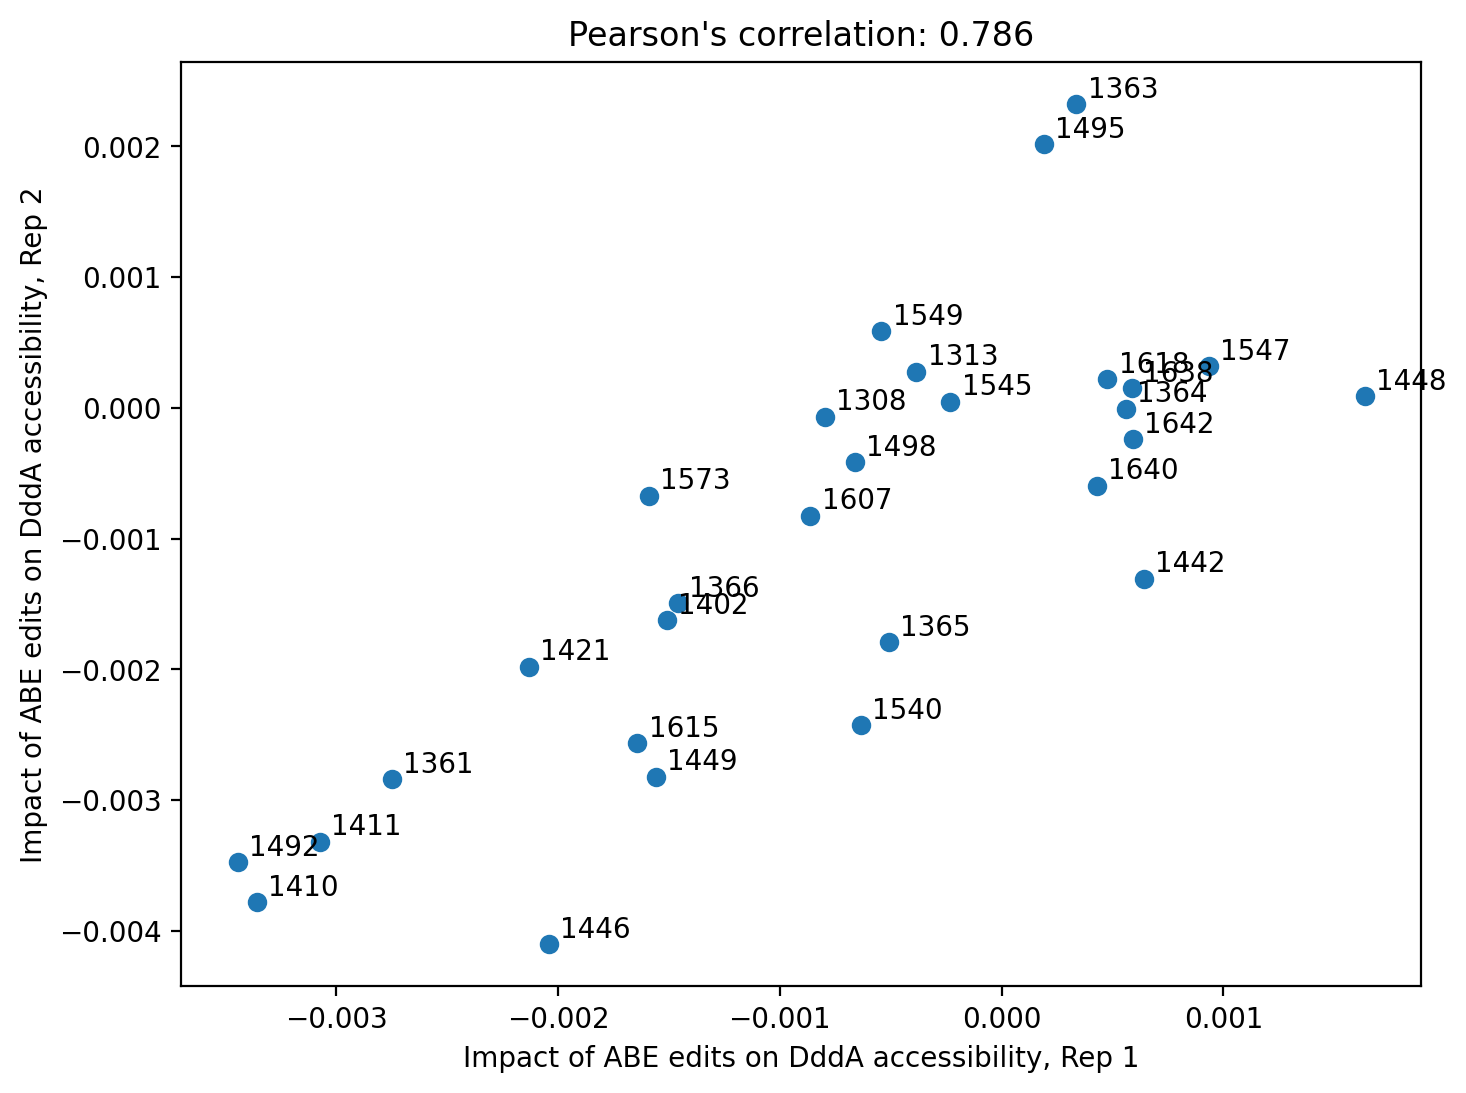

In [17]:
# Visualize the comparison
plt.figure(dpi=200, figsize=(8, 6))
impact_score_1 = np.mean(ABE_effect["HJR244_3"], axis=1)
impact_score_2 = np.mean(ABE_effect["HJR244_4"], axis=1)
plt.scatter(impact_score_1, impact_score_2)
plt.title("Pearson's correlation: " + str(round(ss.pearsonr(impact_score_1, impact_score_2)[0], 3)))
plt.xlabel("Impact of ABE edits on DddA accessibility, Rep 1")
plt.ylabel("Impact of ABE edits on DddA accessibility, Rep 2")
label_offset = (max(impact_score_1) - min(impact_score_1)) * 0.01
for i, site in enumerate(kept_A_pos):
    plt.text(impact_score_1[i] + label_offset, impact_score_2[i] + label_offset, site)
plt.savefig("/home/yanhu/data/DddA/HJR244/plots/ABE_diff_edit_reproducibility/ABE_single_bp_diff_edit_replicate_comparison.pdf")
plt.show()

### Align with TF binding sites

In [19]:
def plot_TF_track(TF_sites, chr, start, end, ax):

    

    # Keep TF sites in the specified region
    region_range = pr.PyRanges(
        chromosomes=chr, 
        starts=[start], 
        ends=[end])
    region_TF_sites = TF_sites.intersect(region_range).df
    region_TF_sites = region_TF_sites.iloc[np.argsort(region_TF_sites["Start"]),:]

    # Merge overlapping motifs of the same TF
    region_TF_site_dict = {}
    for i, row in region_TF_sites.iterrows():
        Chromosome, Start, End, TF = row[["Chromosome", "Start", "End", "TF"]]
        if TF not in region_TF_site_dict:
            region_TF_site_dict[TF] = [[Start, End]]
        else:
            # If the current motif overlaps with the previous motif of the same TF, merge them
            if Start <= region_TF_site_dict[TF][-1][1]:
                region_TF_site_dict[TF][-1][1] = max(region_TF_site_dict[TF][-1][1], End)
            else:
                region_TF_site_dict[TF].append([Start, End])

    # Visualize the motif match track
    from dna_features_viewer import GraphicFeature, GraphicRecord
    features = []
    for TF in region_TF_site_dict:
        for site in region_TF_site_dict[TF]:
            features.append(GraphicFeature(
                start=site[0] - region_start - plot_start, 
                end=site[1] - region_start - plot_start, 
                color=generate_low_saturation_color(), 
                label=TF))
    record = GraphicRecord(sequence_length=plot_end - plot_start, features=features)
    record.plot(ax=ax)

100%|████████████████████████████████████████████████████████████████████| 3478/3478 [00:02<00:00, 1391.42it/s]


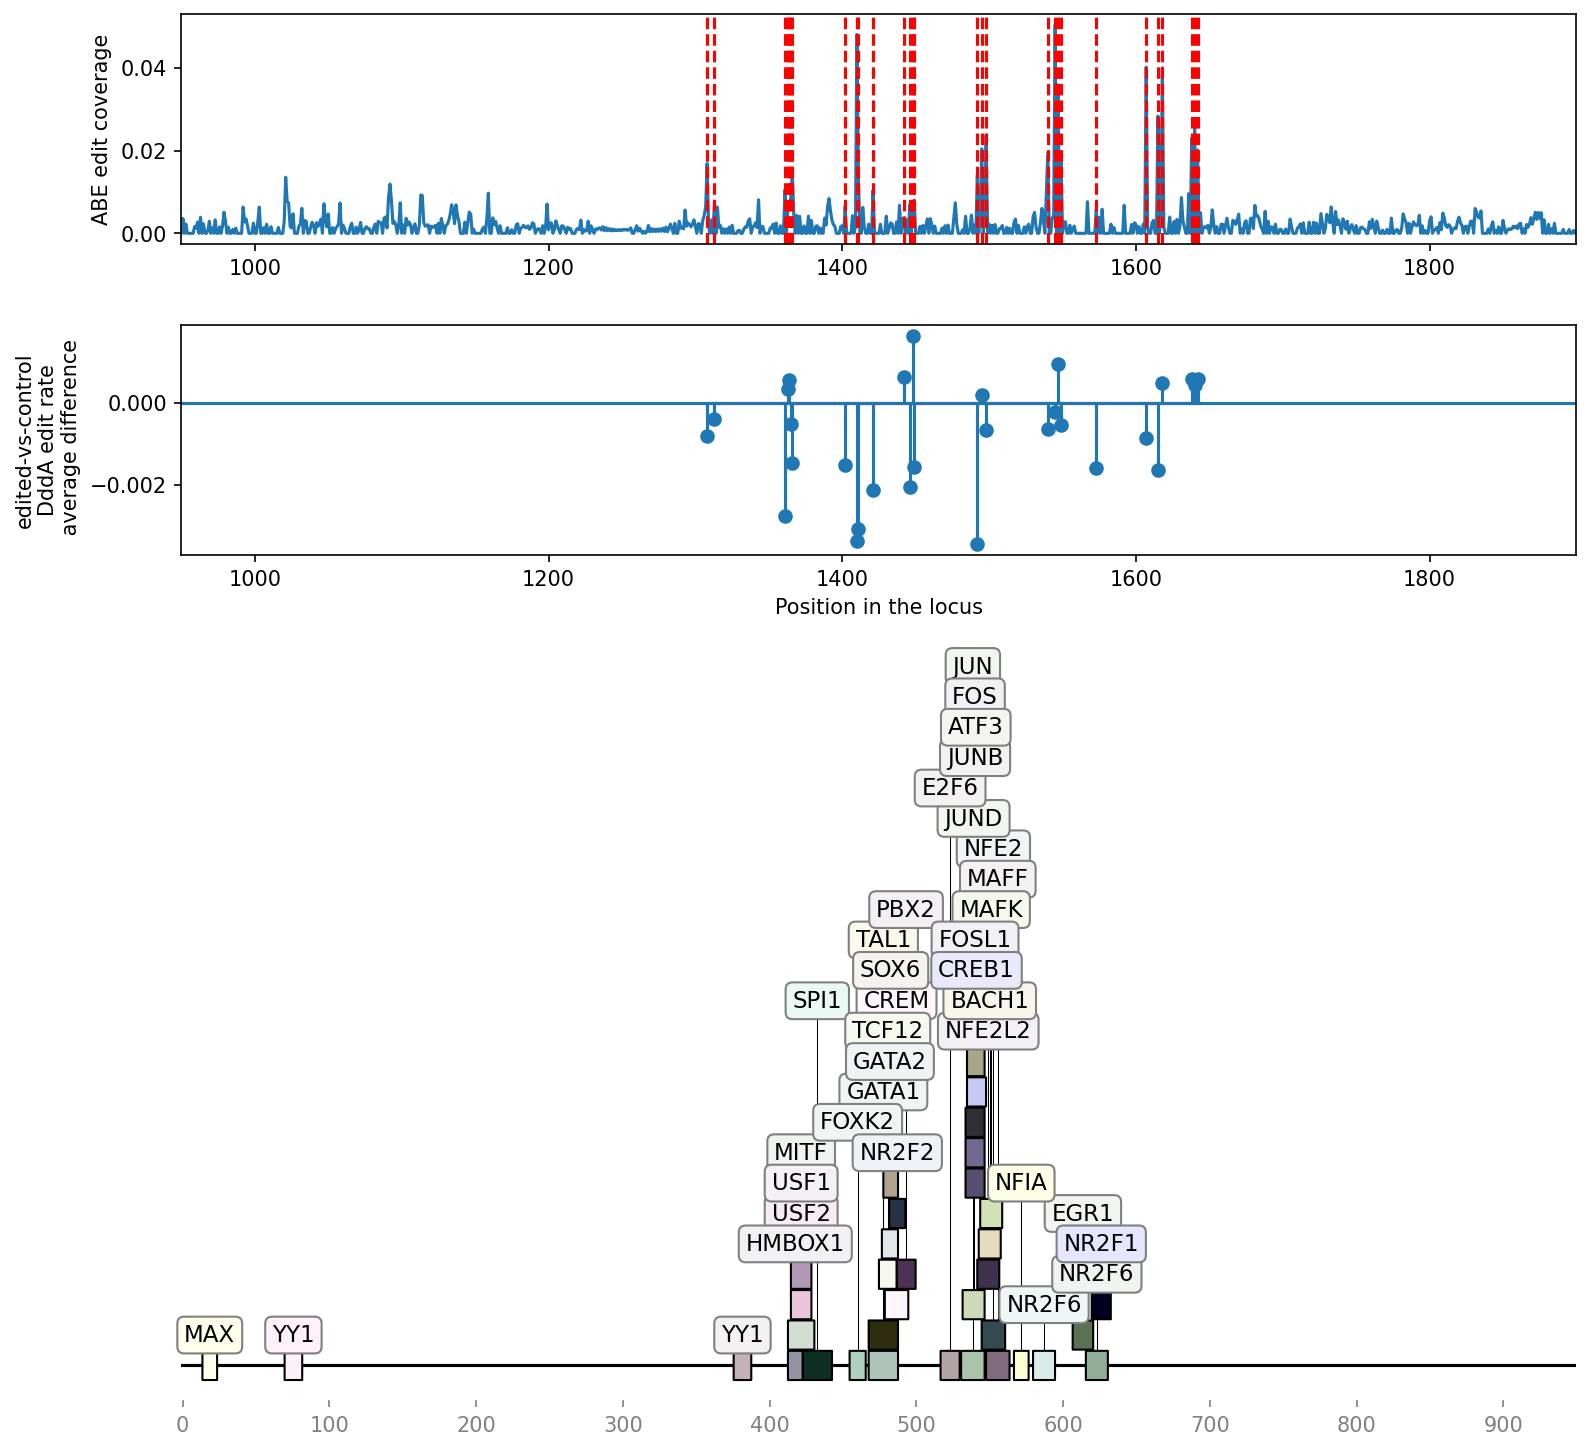

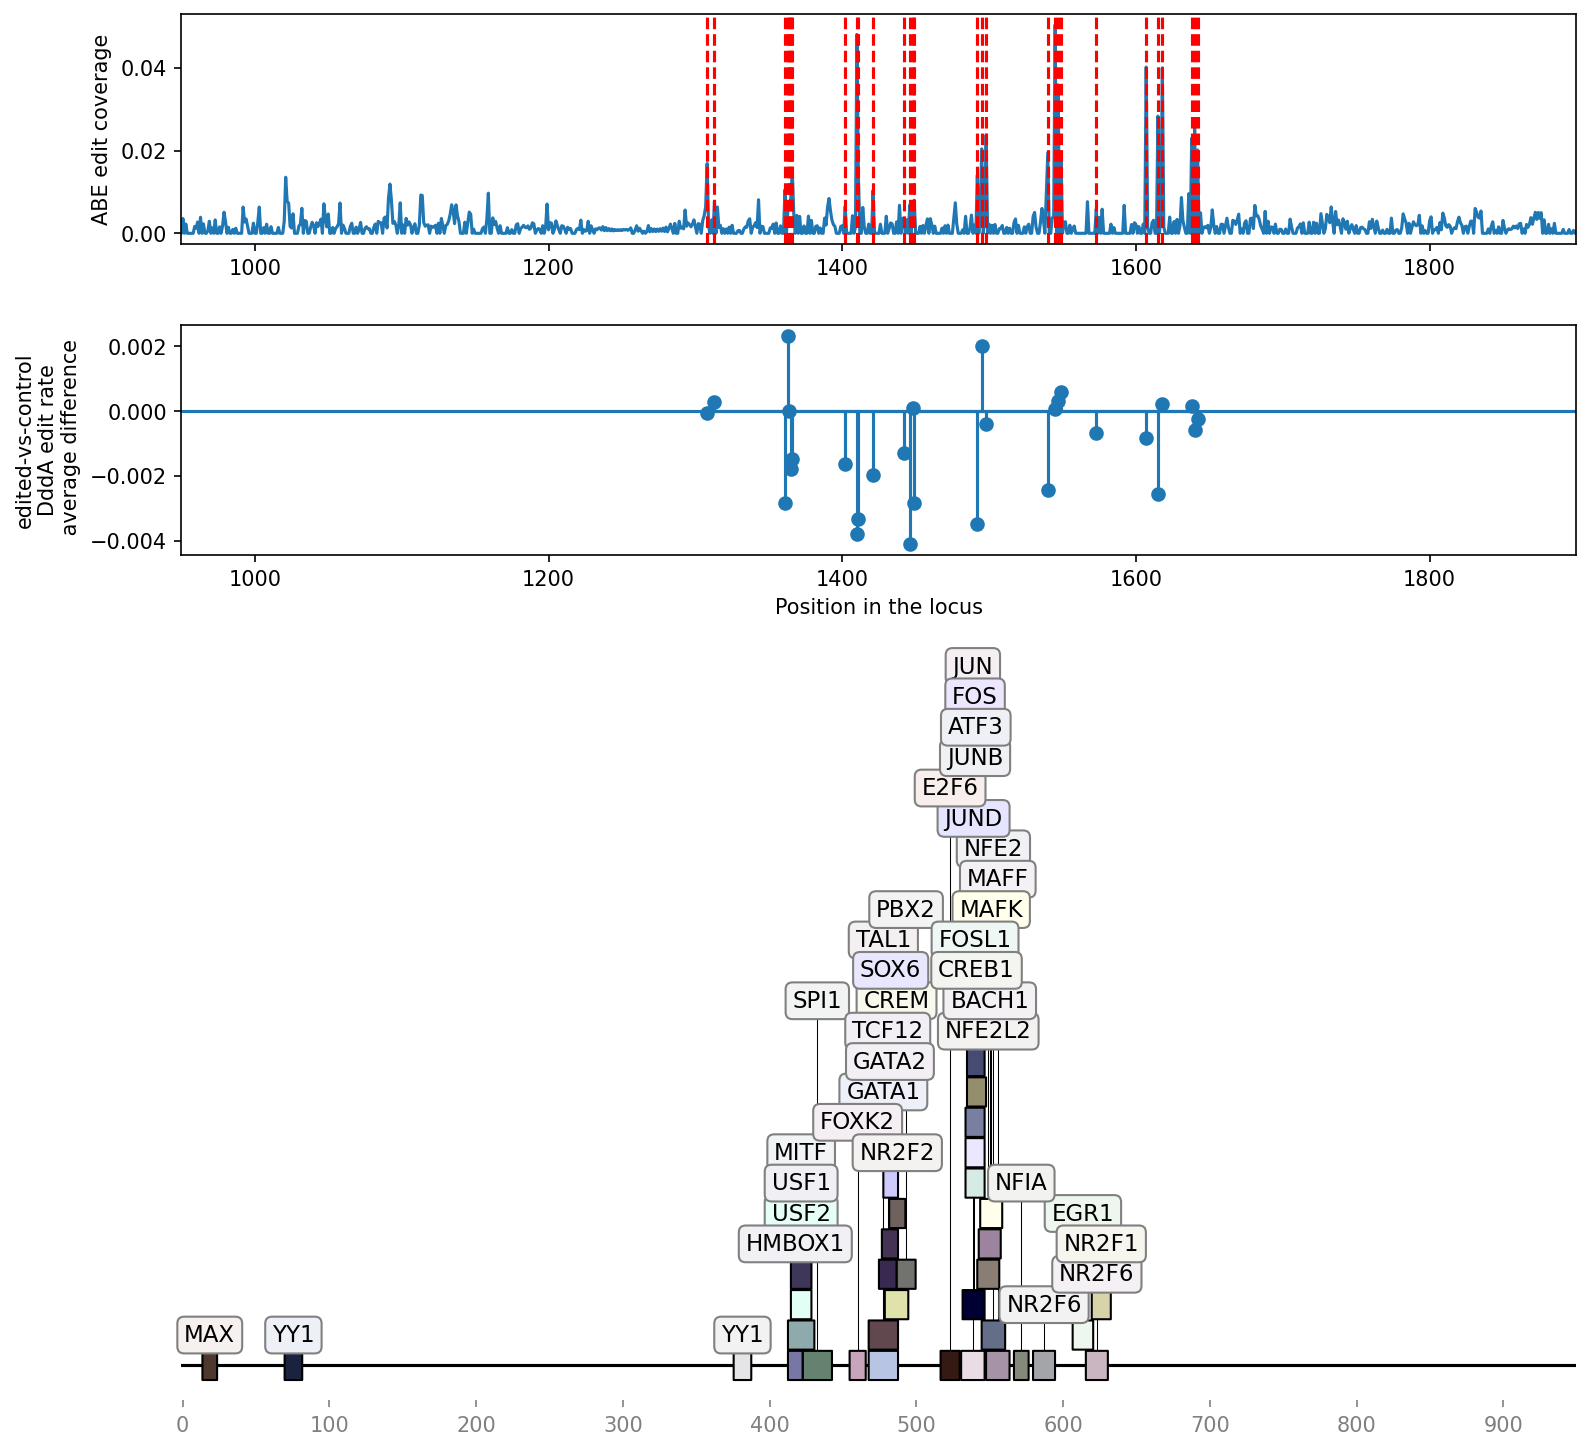

In [23]:
# Load Unibind TF binding sites
unibind_dir = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/shared/unibind/damo_hg38_all_TFBS"
TF_sites = load_unibind_sites(unibind_dir)

# Find TF motifs in the current plotted region
plot_start, plot_end = 950, 1900
region_chr, region_start, region_end = ref_range_dict[locus]
region_plot_start = region_start + plot_start
region_plot_end = region_start + plot_end

for replicate in ["HJR244_3", "HJR244_4"]:
    
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    
    fig, ax = plt.subplots(3, 1, dpi=150, figsize=(12, 12), gridspec_kw={'height_ratios': [1.5, 1.5, 5]})
    
    ax[0].plot(np.arange(len(ABE_coverage)), ABE_coverage)
    for A_pos in kept_A_pos:
        ax[0].axvline(x = A_pos, color="red", linestyle="dashed")
    ax[0].set_ylabel("ABE edit coverage")
    ax[0].set_xlim([plot_start, plot_end])
    
    impact = np.mean(ABE_effect[replicate], axis=1)
    ax[1].stem(kept_A_pos, impact) 
    ax[1].set_xlim([plot_start, plot_end])
    ax[1].set_ylabel("edited-vs-control\nDddA edit rate\n average difference")
    ax[1].set_xlabel("Position in the locus")
    ax[1].axhline(y=0)
    
    plot_TF_track(TF_sites, region_chr, region_plot_start, region_plot_end, ax[2])
    
    plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_edit_" + locus + ".pdf"))
    plt.show()

### Calculate impact of ABE edits on DddA footprints (first aggregating reads)

In [20]:
# Load ddda_dataset objects for both replicates
ddda_dict = {}
for replicate in ["HJR244_3", "HJR244_4"]:
    save_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
    with open(save_path, "rb") as f:
        ddda_dict[replicate] = pickle.load(f)

In [21]:
# Get DddA bias for each strand
stranded_bias = {
    "C_to_T" : ddda_data.bias_dict[locus][:, 0], 
    "G_to_A" : ddda_data.bias_dict[locus][:, 1]
}

ABE_fp_effect = {}
footprint_radius = 50
num_reads = {}
for replicate in ["HJR244_3", "HJR244_4"]:
    ddda_data = ddda_dict[replicate]
    effect_mtx = []
    num_reads[replicate] = []
    for A_pos in kept_A_pos:
        pos_num_reads = []
        diff_footprints = {}
        for strand in ["C_to_T", "G_to_A"]:

            # Retrieve read indices for ABE edited and unedited reads
            edited_read_inds = ABE_results[replicate][A_pos][strand]["edited_read_inds"]
            unedited_read_inds = ABE_results[replicate][A_pos][strand]["unedited_read_inds"]

            # Down sample edited and unedited reads to the same number
            # Otherwise the footpriny scores can't be directly compared
            min_num = min(len(edited_read_inds), len(unedited_read_inds))
            edited_read_inds = np.random.choice(edited_read_inds, min_num, replace=False)
            unedited_read_inds = np.random.choice(unedited_read_inds, min_num, replace=False)
            pos_num_reads.append(min_num)
            
            # Calculate aggregate DddA edit counts
            ABE_edited_DddA_edits = np.array(np.sum(ddda_data.edit_dict[locus][edited_read_inds, :], axis=0))[0, :]
            ABE_unedited_DddA_edits = np.array(np.sum(ddda_data.edit_dict[locus][unedited_read_inds, :], axis=0))[0, :]

            # Calculate DddA footprints
            footprints_edited = get_footprint_single_scale(
                ABE_edited_DddA_edits, stranded_bias[strand], 
                fp_radius=footprint_radius, combine_sides="max_pval") 
            footprints_unedited = get_footprint_single_scale(
                ABE_unedited_DddA_edits, stranded_bias[strand], 
                fp_radius=footprint_radius, combine_sides="max_pval")

            # Convert to -log10 pvals
            footprints_edited = -np.log10(np.squeeze(footprints_edited) + 1e-300)
            footprints_unedited = -np.log10(np.squeeze(footprints_unedited) + 1e-300)
            
            # Calculate the difference of average footprint between ABE edited and unedited reads
            diff_footprints[strand] = footprints_edited - footprints_unedited

        mean_diff_footprints = (diff_footprints["C_to_T"] + diff_footprints["G_to_A"]) / 2
        mean_diff_footprints = np.convolve(mean_diff_footprints, np.ones(50), mode="same") / 50
        effect_mtx.append(mean_diff_footprints)
        num_reads[replicate].append(np.mean(pos_num_reads))
    
    ABE_fp_effect[replicate] = np.array(effect_mtx)

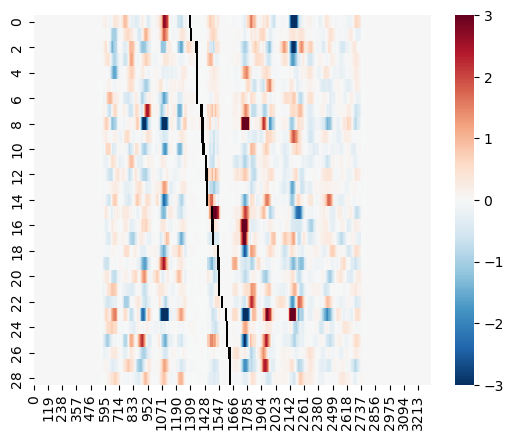

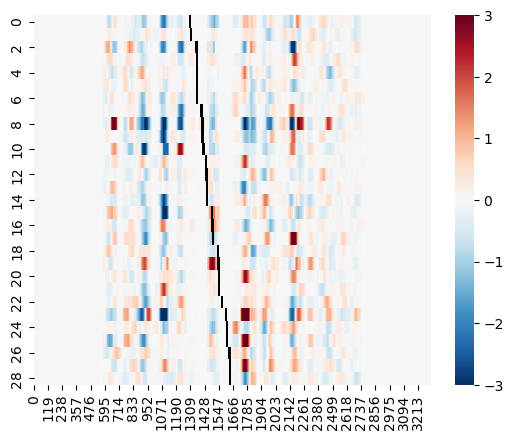

In [22]:
for replicate in ["HJR244_3", "HJR244_4"]:
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    
    # Visualize base edit impact using a heatmap
    sns.heatmap(
        ABE_fp_effect[replicate], 
        cmap=cmap,
        mask=ABE_mask, vmax=3, vmin=-3)
    plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_fp_heatmap_" + replicate + ".png"))
    plt.show()

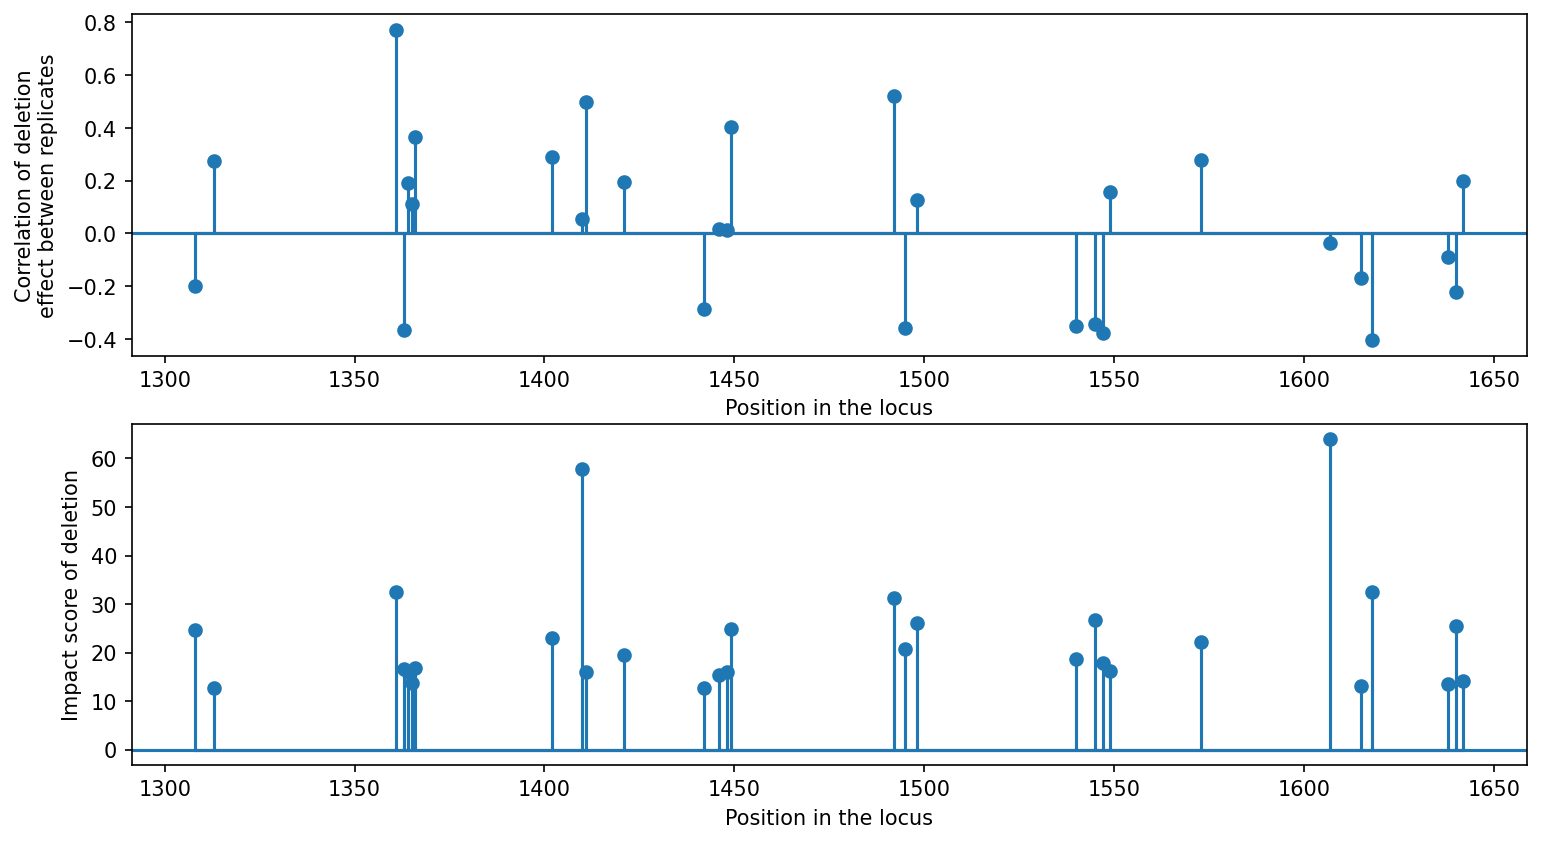

In [23]:
# Calculate correlation between replicates for each sgRNA
replicate_cor = []
for A_pos_ind in range(len(kept_A_pos)):
    replicate_cor.append(ss.pearsonr(
        ABE_fp_effect["HJR244_3"][A_pos_ind, :],
        ABE_fp_effect["HJR244_4"][A_pos_ind, :]
    ).statistic)

# Calculate overall impact for each sgRNA
impact_score = []
for A_pos_ind in range(len(kept_A_pos)):
    score_1 = np.sqrt(np.sum(np.power(ABE_fp_effect["HJR244_3"][A_pos_ind, :], 2)))
    score_2 = np.sqrt(np.sum(np.power(ABE_fp_effect["HJR244_4"][A_pos_ind, :], 2)))
    impact_score.append(min(score_1, score_2))

# Calculate the read depth of each position
read_depth = (np.array(num_reads["HJR244_3"]) + np.array(num_reads["HJR244_4"])) / 2

plot_dir = "/home/yanhu/data/DddA/HJR244/plots/ABE_diff_fp_reproducibility/"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(12, 6.5))

ax[0].stem(kept_A_pos, replicate_cor) 
ax[0].set_ylabel("Correlation of deletion\neffect between replicates")
ax[0].set_xlabel("Position in the locus")
ax[0].axhline(y=0)

ax[1].stem(kept_A_pos, impact_score) 
ax[1].set_ylabel("Impact score of deletion")
ax[1].set_xlabel("Position in the locus")
ax[1].axhline(y=0)

plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_fp_reproducibility.pdf"))

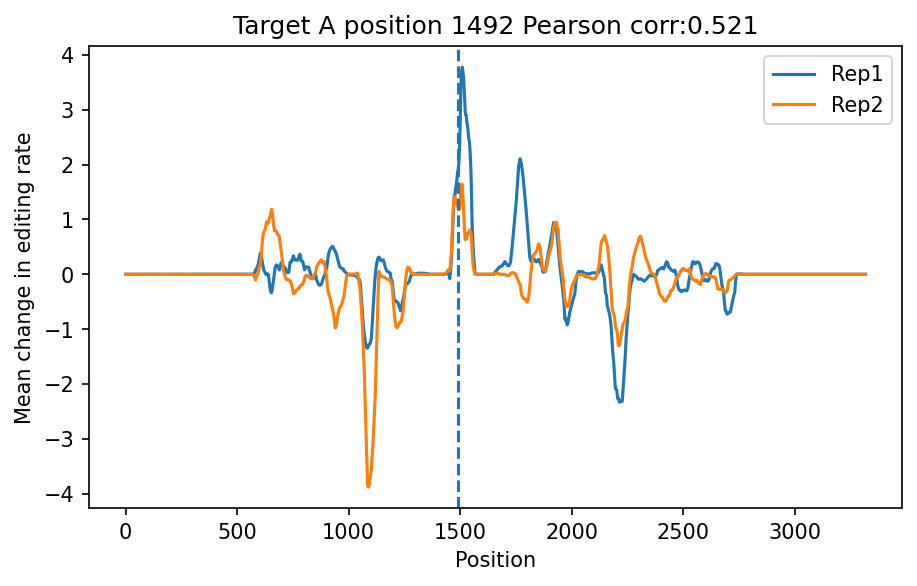

In [24]:
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/ABE_diff_fp_reproducibility/"
plt.figure(dpi=150, figsize=(7, 4))
A_pos_ind = 15
A_pos = kept_A_pos[A_pos_ind]
cor = ss.pearsonr(ABE_fp_effect["HJR244_3"][A_pos_ind], ABE_fp_effect["HJR244_4"][A_pos_ind])[0]
plt.title("Target A position " + str(A_pos) + " Pearson corr:" + str(round(cor, 3)))
plt.xlabel("Position")
plt.ylabel("Mean change in editing rate")
plt.plot(ABE_fp_effect["HJR244_3"][A_pos_ind], label="Rep1")
plt.plot(ABE_fp_effect["HJR244_4"][A_pos_ind], label="Rep2")
plt.axvline(x=A_pos, linestyle="dashed")
plt.legend()
plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_fp_reproducibility_sgRNA_" + str(A_pos) + ".pdf"))

# Calculate impact of ABE edits on DddA footprints (first footprinting single reads)

In [25]:
# Get DddA bias for each strand
stranded_bias = {
    "C_to_T" : ddda_data.bias_dict[locus][:, 0], 
    "G_to_A" : ddda_data.bias_dict[locus][:, 1]
}

ABE_fp_effect = {}
footprint_radii = [50]
num_reads = {}
for replicate in ["HJR244_3", "HJR244_4"]:
    ddda_data = ddda_dict[replicate]
    effect_mtx = []
    num_reads[replicate] = []
    for A_pos in kept_A_pos:
        pos_num_reads = []
        diff_footprints = {}
        for strand in ["C_to_T", "G_to_A"]:
            grouped_footprints = {}
            for ABE_group in ["edited", "unedited"]:

                # Retrieve read indices
                read_inds = ABE_results[replicate][A_pos][strand][ABE_group + "_read_inds"]

                # Calculate footprints
                footprints_dict = ddda_data.get_footprints(
                    {locus:np.array(ddda_data.read_ids[locus])[read_inds]}, 
                    footprint_radii = [50], 
                    combine_sides="max_pval")
                footprints = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
                footprints = -np.log10(footprints + 1e-300)
                footprints = np.mean(footprints, axis=0)
                grouped_footprints[ABE_group] = footprints
                
            # Calculate the difference of average footprint between ABE edited and unedited reads
            diff_footprints[strand] = grouped_footprints["edited"] - grouped_footprints["unedited"]

        mean_diff_footprints = (diff_footprints["C_to_T"] + diff_footprints["G_to_A"]) / 2
        mean_diff_footprints = np.convolve(mean_diff_footprints, np.ones(50), mode="same") / 50
        effect_mtx.append(mean_diff_footprints)
        num_reads[replicate].append(np.mean(pos_num_reads))
    
    ABE_fp_effect[replicate] = np.array(effect_mtx)

with open("/home/yanhu/data/DddA/HJR244/ABE_fp_effect_single_read.pkl", "wb") as f:
    pickle.dump(ABE_fp_effect, f)

Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 270/270 [00:10<00:00, 25.97it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 871/871 [00:32<00:00, 26.61it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 339/339 [00:14<00:00, 24.00it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1196/1196 [00:47<00:00, 25.36it/s]
/home/yanhu/utils/miniforge3/envs/DddA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yanhu/utils/miniforge3/envs/DddA/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.55it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 29.08it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 131/131 [00:04<00:00, 28.90it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 133/133 [00:05<00:00, 26.45it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 389/389 [00:14<00:00, 26.46it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 927/927 [00:36<00:00, 25.70it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 351/351 [00:14<00:00, 25.07it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1289/1289 [00:49<00:00, 26.25it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 25.66it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 26.38it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 109/109 [00:04<00:00, 26.83it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 116/116 [00:04<00:00, 26.85it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 28.16it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 95/95 [00:03<00:00, 27.66it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.31it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 24.34it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 26.51it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 25.42it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 25.61it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 28.96it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 24.92it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.64it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 322/322 [00:12<00:00, 25.64it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 438/438 [00:16<00:00, 26.17it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00, 27.33it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 363/363 [00:13<00:00, 27.32it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 201/201 [00:07<00:00, 25.65it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.51it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1447/1447 [00:57<00:00, 25.31it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2837/2837 [01:51<00:00, 25.34it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 647/647 [00:26<00:00, 24.77it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 3387/3387 [02:09<00:00, 26.14it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 167/167 [00:06<00:00, 25.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 154/154 [00:05<00:00, 28.97it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 23.58it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 232/232 [00:08<00:00, 26.62it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 247/247 [00:09<00:00, 25.59it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 675/675 [00:25<00:00, 26.47it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 443/443 [00:17<00:00, 24.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 879/879 [00:33<00:00, 26.58it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 89/89 [00:03<00:00, 26.60it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 25.93it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 28.00it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 110/110 [00:04<00:00, 26.55it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 27.12it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 353/353 [00:13<00:00, 26.81it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 27.17it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 431/431 [00:16<00:00, 26.58it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 112/112 [00:04<00:00, 26.78it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 85/85 [00:03<00:00, 27.70it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.00it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 26.95it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 303/303 [00:12<00:00, 24.86it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 788/788 [00:29<00:00, 26.66it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 266/266 [00:09<00:00, 27.56it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1098/1098 [00:42<00:00, 25.72it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 253/253 [00:10<00:00, 25.22it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 745/745 [00:28<00:00, 25.82it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 322/322 [00:12<00:00, 26.24it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1015/1015 [00:38<00:00, 26.50it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 123/123 [00:05<00:00, 23.64it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 168/168 [00:06<00:00, 26.09it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 90/90 [00:03<00:00, 25.06it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 243/243 [00:09<00:00, 25.49it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 212/212 [00:07<00:00, 27.69it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 450/450 [00:17<00:00, 25.96it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 235/235 [00:08<00:00, 26.38it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 636/636 [00:24<00:00, 26.14it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 141/141 [00:05<00:00, 26.31it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 158/158 [00:05<00:00, 27.55it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 131/131 [00:04<00:00, 26.27it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 216/216 [00:08<00:00, 24.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 318/318 [00:12<00:00, 26.10it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 867/867 [00:32<00:00, 26.38it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 491/491 [00:19<00:00, 25.25it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1171/1171 [00:45<00:00, 25.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 140/140 [00:05<00:00, 25.18it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 281/281 [00:10<00:00, 26.81it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 226/226 [00:08<00:00, 25.37it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 416/416 [00:16<00:00, 25.58it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 92/92 [00:03<00:00, 23.02it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 27.58it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.29it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 131/131 [00:04<00:00, 27.67it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 24.94it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 533/533 [00:19<00:00, 26.87it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 301/301 [00:11<00:00, 25.63it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 737/737 [00:28<00:00, 25.70it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1228/1228 [00:48<00:00, 25.13it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2773/2773 [01:47<00:00, 25.79it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1124/1124 [00:45<00:00, 24.70it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 3499/3499 [02:14<00:00, 25.94it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 146/146 [00:05<00:00, 26.75it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00, 28.67it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 185/185 [00:07<00:00, 25.32it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 223/223 [00:07<00:00, 28.24it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 427/427 [00:17<00:00, 24.55it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1451/1451 [00:55<00:00, 26.33it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 577/577 [00:21<00:00, 26.86it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1841/1841 [01:10<00:00, 26.14it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 26.89it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.76it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 131/131 [00:04<00:00, 27.77it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 142/142 [00:05<00:00, 26.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 24.05it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 190/190 [00:07<00:00, 25.46it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 163/163 [00:05<00:00, 28.84it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 285/285 [00:10<00:00, 26.47it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 29.44it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 26.57it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 27.77it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.30it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 296/296 [00:04<00:00, 62.42it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 865/865 [00:13<00:00, 64.98it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 287/287 [00:04<00:00, 63.35it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1205/1205 [00:19<00:00, 63.31it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 66.83it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 68.33it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 64.87it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 132/132 [00:01<00:00, 72.06it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 364/364 [00:05<00:00, 62.03it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 955/955 [00:14<00:00, 66.11it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 351/351 [00:05<00:00, 62.94it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1345/1345 [00:21<00:00, 63.25it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 56.38it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 86/86 [00:01<00:00, 65.58it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 57.82it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 138/138 [00:02<00:00, 58.29it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 62.44it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 68.95it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 65.82it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 62.41it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 62.75it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 59.60it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 141/141 [00:02<00:00, 65.36it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 141/141 [00:02<00:00, 62.09it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 205/205 [00:02<00:00, 68.84it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 409/409 [00:06<00:00, 67.60it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 340/340 [00:05<00:00, 63.13it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 564/564 [00:08<00:00, 65.80it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 145/145 [00:02<00:00, 63.24it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 340/340 [00:05<00:00, 63.94it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 239/239 [00:03<00:00, 64.44it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 555/555 [00:08<00:00, 64.04it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1314/1314 [00:21<00:00, 60.40it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2600/2600 [00:40<00:00, 64.07it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 654/654 [00:10<00:00, 61.48it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 3693/3693 [00:58<00:00, 62.75it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 172/172 [00:02<00:00, 62.65it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 63.45it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:03<00:00, 63.04it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 282/282 [00:04<00:00, 65.29it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 249/249 [00:04<00:00, 61.31it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 744/744 [00:11<00:00, 62.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 449/449 [00:06<00:00, 64.15it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1116/1116 [00:17<00:00, 62.43it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 65.60it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 65.15it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 60.93it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 69.70it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 61.95it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 298/298 [00:04<00:00, 64.38it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 141/141 [00:02<00:00, 63.00it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 447/447 [00:07<00:00, 61.41it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 134/134 [00:02<00:00, 62.49it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 95/95 [00:01<00:00, 60.94it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 64.98it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 142/142 [00:02<00:00, 65.75it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 299/299 [00:04<00:00, 62.81it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 809/809 [00:12<00:00, 64.87it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 280/280 [00:04<00:00, 66.39it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1058/1058 [00:16<00:00, 63.13it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 246/246 [00:04<00:00, 57.47it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 858/858 [00:13<00:00, 64.08it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 340/340 [00:05<00:00, 63.78it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1176/1176 [00:18<00:00, 62.06it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 60.90it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 189/189 [00:03<00:00, 61.47it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 66.81it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 296/296 [00:04<00:00, 66.49it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 229/229 [00:03<00:00, 65.10it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 558/558 [00:08<00:00, 65.76it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 257/257 [00:03<00:00, 65.14it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 815/815 [00:12<00:00, 64.21it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 111/111 [00:01<00:00, 60.94it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 203/203 [00:03<00:00, 65.66it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 172/172 [00:02<00:00, 62.46it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 307/307 [00:04<00:00, 62.70it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 935/935 [00:14<00:00, 63.30it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 484/484 [00:07<00:00, 62.09it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1338/1338 [00:20<00:00, 63.93it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 132/132 [00:02<00:00, 62.01it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.53it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 249/249 [00:03<00:00, 65.40it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 65.44it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 86/86 [00:01<00:00, 60.34it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 103/103 [00:01<00:00, 65.74it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 58.82it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 174/174 [00:02<00:00, 64.89it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 260/260 [00:04<00:00, 61.72it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 532/532 [00:08<00:00, 63.93it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 328/328 [00:05<00:00, 62.18it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 827/827 [00:12<00:00, 64.57it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1226/1226 [00:19<00:00, 61.60it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2638/2638 [00:42<00:00, 62.18it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1021/1021 [00:16<00:00, 61.76it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 3669/3669 [00:58<00:00, 62.98it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 65.40it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 149/149 [00:02<00:00, 61.79it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 174/174 [00:02<00:00, 68.27it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 63.58it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 466/466 [00:07<00:00, 61.77it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1370/1370 [00:21<00:00, 62.87it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 534/534 [00:08<00:00, 62.75it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2016/2016 [00:31<00:00, 63.12it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 106/106 [00:01<00:00, 60.91it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 112/112 [00:01<00:00, 63.58it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 126/126 [00:01<00:00, 64.50it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 67.55it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 138/138 [00:02<00:00, 66.76it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 228/228 [00:03<00:00, 66.01it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 217/217 [00:03<00:00, 66.20it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 63.48it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 62.93it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 103/103 [00:01<00:00, 61.32it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 66.06it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 152/152 [00:02<00:00, 67.91it/s]


In [18]:
with open("/home/yanhu/data/DddA/HJR244/ABE_fp_effect_single_read.pkl", "rb") as f:
    ABE_fp_effect = pickle.load(f)

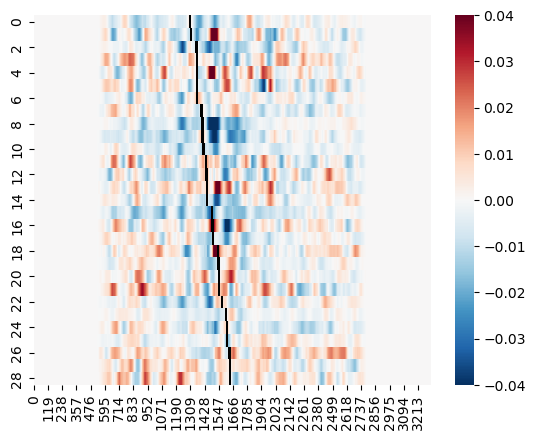

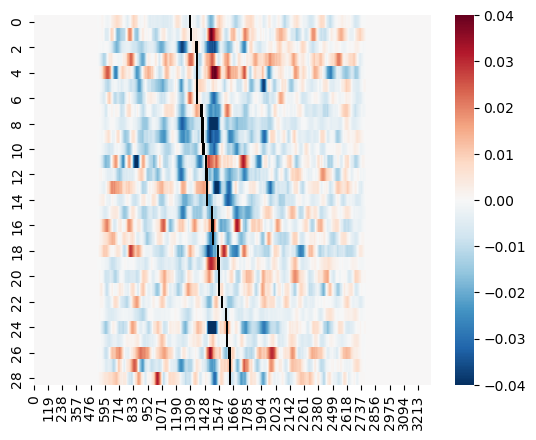

In [19]:
for replicate in ["HJR244_3", "HJR244_4"]:
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    
    # Visualize base edit impact using a heatmap
    ax = sns.heatmap(
        ABE_fp_effect[replicate], 
        cmap=cmap,
        mask=ABE_mask, vmax=0.04, vmin=-0.04)
    ax.collections[0].set_rasterized(True)
    plt.savefig(os.path.join(plot_dir, "ABE_single_bp_single_read_diff_fp_heatmap_" + replicate + ".pdf"))
    plt.show()

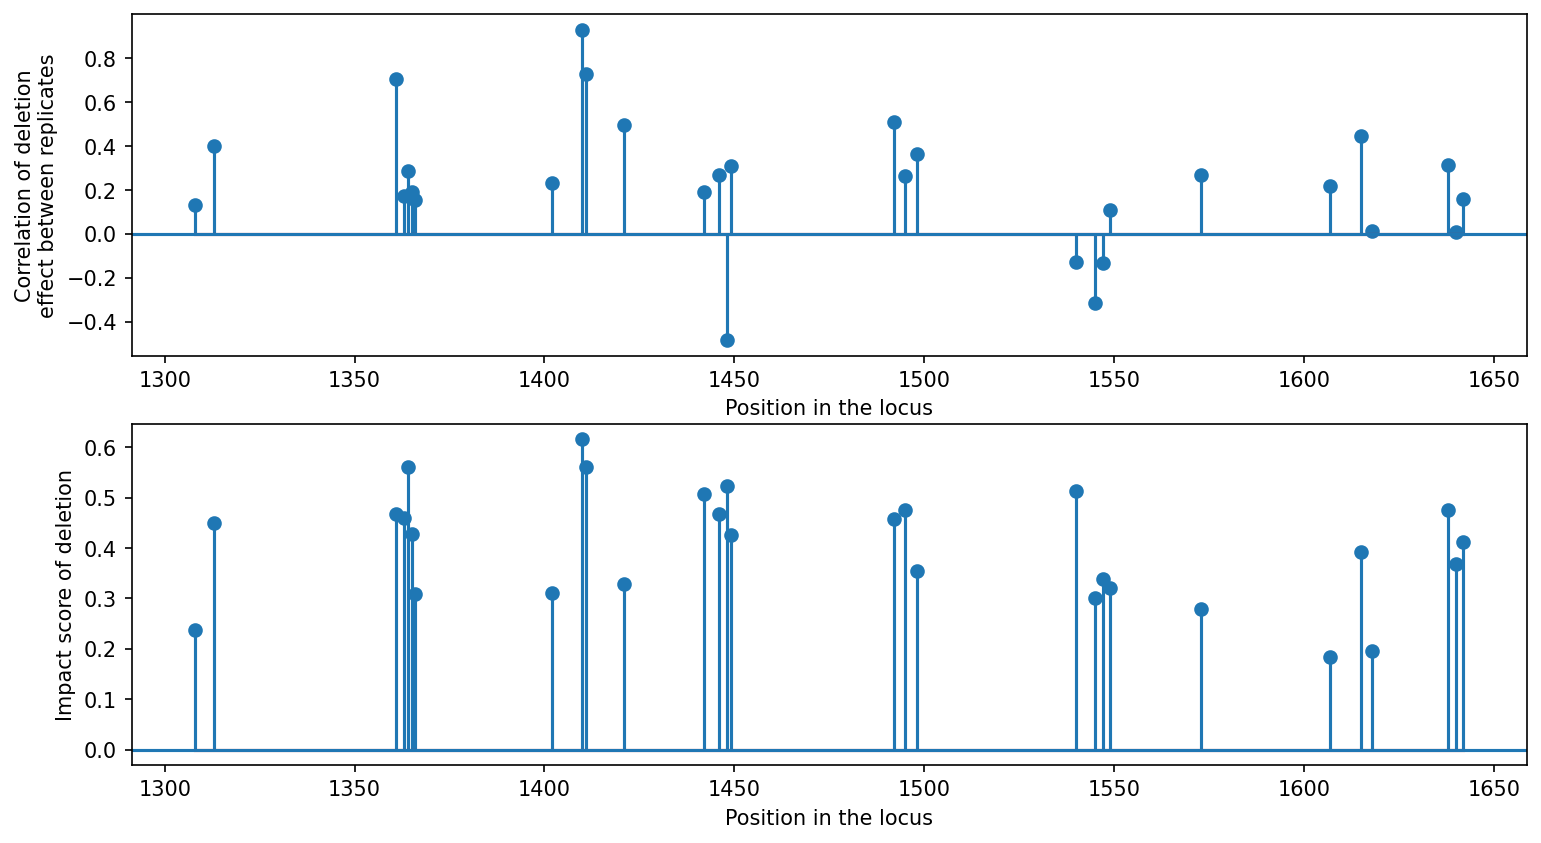

In [28]:
# Calculate correlation between replicates for each sgRNA
replicate_cor = []
for A_pos_ind in range(len(kept_A_pos)):
    replicate_cor.append(ss.pearsonr(
        ABE_fp_effect["HJR244_3"][A_pos_ind, :],
        ABE_fp_effect["HJR244_4"][A_pos_ind, :]
    ).statistic)

# Calculate overall impact for each sgRNA
impact_score = []
for A_pos_ind in range(len(kept_A_pos)):
    score_1 = np.sqrt(np.sum(np.power(ABE_fp_effect["HJR244_3"][A_pos_ind, :], 2)))
    score_2 = np.sqrt(np.sum(np.power(ABE_fp_effect["HJR244_4"][A_pos_ind, :], 2)))
    impact_score.append(min(score_1, score_2))

# Calculate the read depth of each position
read_depth = (np.array(num_reads["HJR244_3"]) + np.array(num_reads["HJR244_4"])) / 2

plot_dir = "/home/yanhu/data/DddA/HJR244/plots/ABE_diff_fp_reproducibility/"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(12, 6.5))

ax[0].stem(kept_A_pos, replicate_cor) 
ax[0].set_ylabel("Correlation of deletion\neffect between replicates")
ax[0].set_xlabel("Position in the locus")
ax[0].axhline(y=0)

ax[1].stem(kept_A_pos, impact_score) 
ax[1].set_ylabel("Impact score of deletion")
ax[1].set_xlabel("Position in the locus")
ax[1].axhline(y=0)

plt.savefig(os.path.join(plot_dir, "ABE_single_bp_single_read_diff_fp_reproducibility.pdf"))

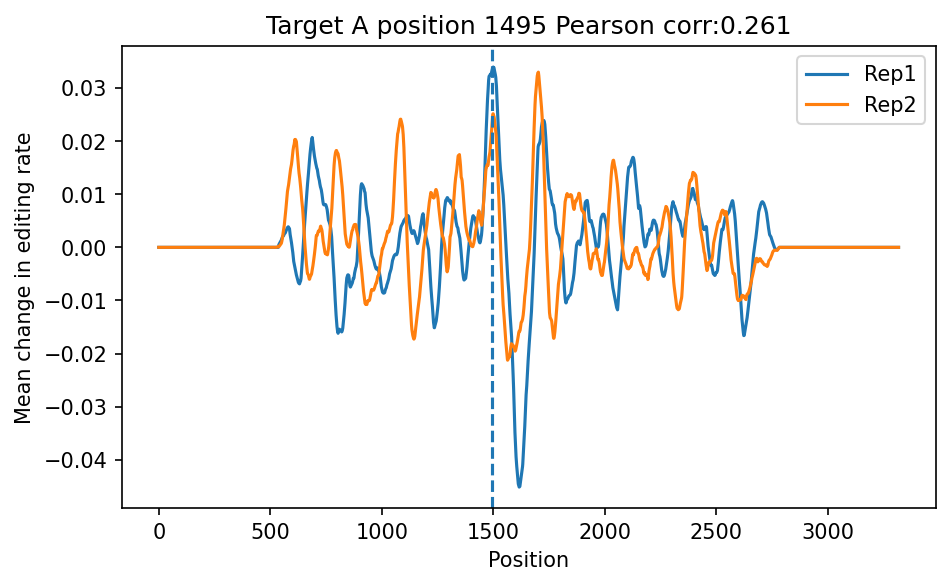

In [29]:
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/ABE_diff_fp_reproducibility/"
plt.figure(dpi=150, figsize=(7, 4))
A_pos_ind = 16
A_pos = kept_A_pos[A_pos_ind]
cor = ss.pearsonr(ABE_fp_effect["HJR244_3"][A_pos_ind], ABE_fp_effect["HJR244_4"][A_pos_ind])[0]
plt.title("Target A position " + str(A_pos) + " Pearson corr:" + str(round(cor, 3)))
plt.xlabel("Position")
plt.ylabel("Mean change in editing rate")
plt.plot(ABE_fp_effect["HJR244_3"][A_pos_ind], label="Rep1")
plt.plot(ABE_fp_effect["HJR244_4"][A_pos_ind], label="Rep2")
plt.axvline(x=A_pos, linestyle="dashed")
plt.legend()
plt.savefig(os.path.join(plot_dir, "ABE_single_bp_single_read_diff_fp_reproducibility_sgRNA_" + str(A_pos) + ".pdf"))